# Master notebook

Imports

In [84]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'
print(sys.path)

if module_dir not in sys.path:
    sys.path.append(module_dir)

print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata
from dataloaders import *

from jax import config
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python310.zip', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/lib-dynload', '', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages', '/Users/tomcowperthwaite/Documents/GitHub/pyqg_parameterization_benchmarks/src', '../']
['/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python310.zip', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/lib-dynload', '', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages', '/Users/tomcowperthwaite/Documents/GitHub/pyqg_parameterization_benchmarks/src', '../']


Load data

In [85]:
problem = 'darcy'
n_train = 1000
n_test = 1000
r = 15

if problem == 'darcy':
    dataloader_params = [n_train, n_test, r]
    s = int(((421 - 1) / r) + 1)
    extent = [0, 1, 0, 1]
    x_cmap = 'coolwarm'
    y_cmap = 'viridis'
elif problem == 'ns':
    dataloader_params = [n_train, n_test]
    s = 64
    extent = [0, 2*np.pi, 0, 2*np.pi]
    x_cmap = 'viridis'
    y_cmap = 'viridis'
elif problem == 'helm':
    dataloader_params = [n_train, n_test]
    s = 101
    extent = [0, 1, 0, 1]
    x_cmap = 'viridis'
    y_cmap = 'coolwarm'

dataloader_dict = {'darcy':get_darcy_data, 'ns':get_navier_stokes_data, 'helm':get_helmholtz_data}
x_train, y_train, x_test, y_test, x_grid, y_grid = dataloader_dict[problem](*dataloader_params)

Visualise input and output data

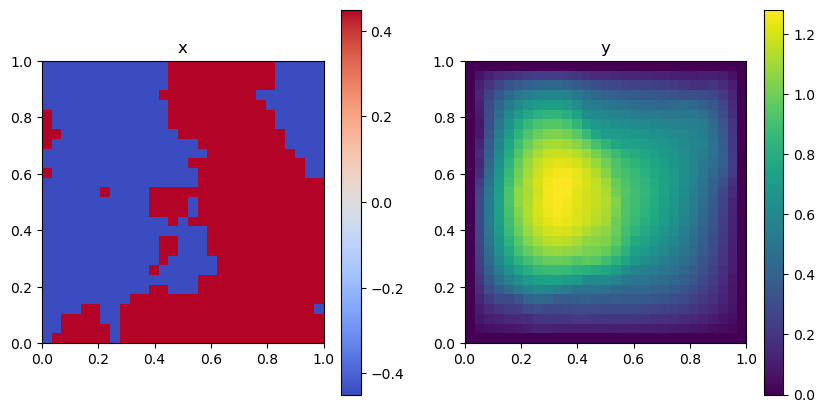

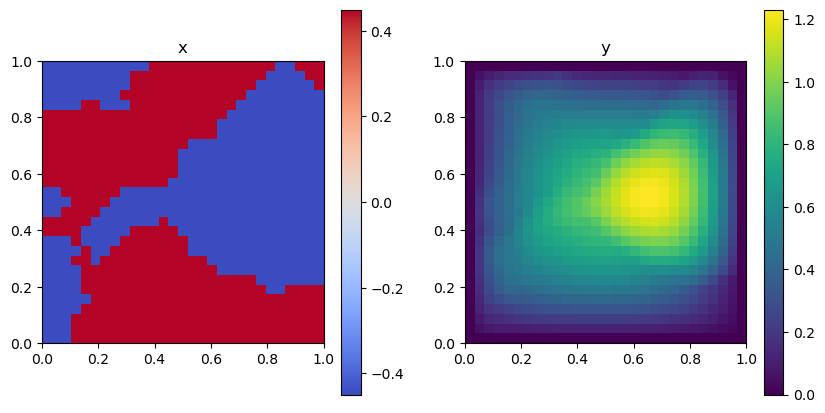

In [86]:
index_to_plot = 12

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap=x_cmap)
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap=y_cmap)
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

index_to_plot = 125

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap=x_cmap)
ax[0].set_title("x")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap=y_cmap)
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

Define model

In [68]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

Determine the number of PCs required to capture a given amount of variance

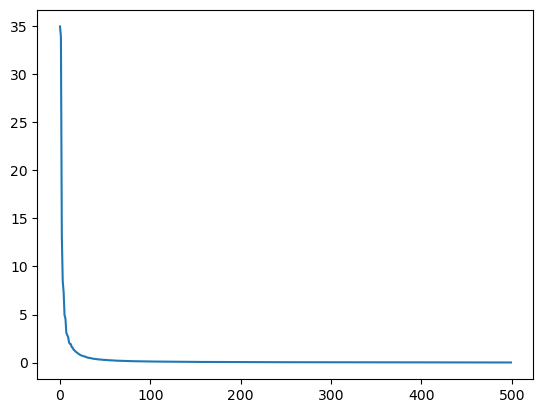

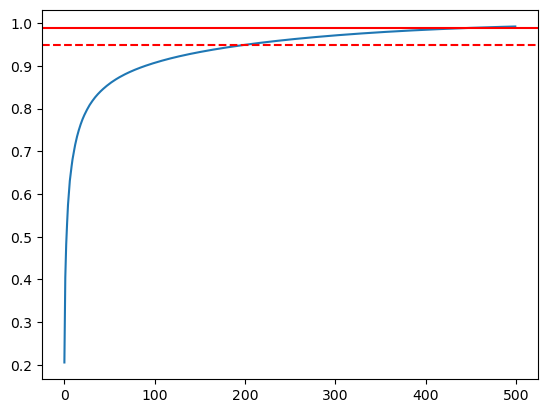

[0.20534478 0.40448362 0.4820604  0.531803   0.5748791  0.60384154
 0.63076043 0.64886224 0.66568315 0.68124354 0.6935271  0.70493495
 0.7161682  0.7255801  0.7346941  0.7425402  0.7500121  0.75685006
 0.76324165 0.76925695 0.77473193 0.7798577  0.78467315 0.7891168
 0.7934274  0.79749984 0.8013311  0.80509573 0.8087656  0.81200856
 0.81518793 0.81815326 0.8210081  0.82381976 0.8265722  0.8290868
 0.83151084 0.83389795 0.836161   0.8383518  0.84046316 0.84253407
 0.8444882  0.8464205  0.848306   0.85014874 0.8519135  0.8536423
 0.85531324 0.8569622  0.85855776 0.8601246  0.86167794 0.863133
 0.86456823 0.86595076 0.86731434 0.86866105 0.8699835  0.871267
 0.87253094 0.8737241  0.8748899  0.87604994 0.87719464 0.8783057
 0.87940705 0.8804886  0.8815485  0.8825626  0.88357186 0.8845751
 0.8855516  0.88650733 0.88746136 0.8883904  0.88931066 0.8902029
 0.89107114 0.89193803 0.8927791  0.89360386 0.89442354 0.89523166
 0.8960298  0.89682496 0.89759475 0.8983577  0.89910555 0.89985186
 0.90

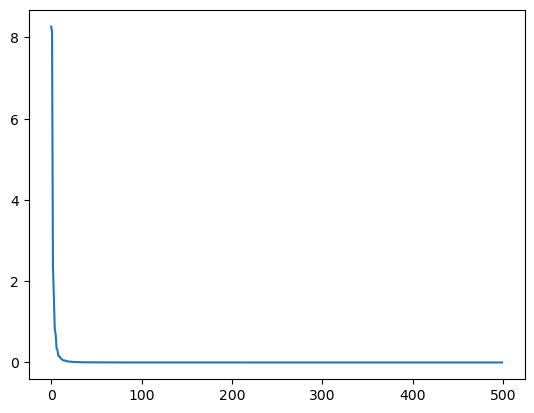

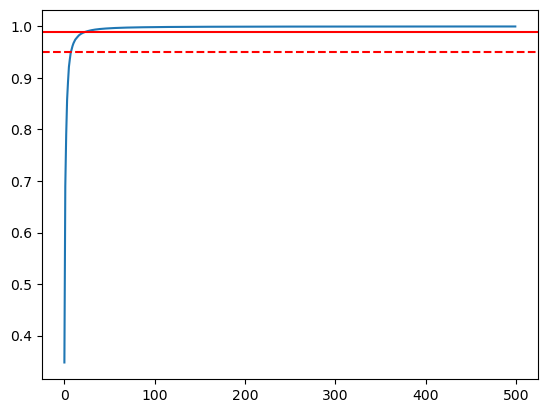

[0.34768012 0.689976   0.79040915 0.85778546 0.8925259  0.92151904
 0.93611276 0.948843   0.95561856 0.96203345 0.9671421  0.97094256
 0.9743744  0.9766436  0.9786855  0.98070383 0.98265696 0.98400307
 0.9852877  0.98632205 0.98724127 0.9880404  0.9888     0.9894856
 0.99006486 0.9906072  0.9910934  0.9915534  0.9919698  0.9923614
 0.9927507  0.993094   0.9934037  0.99369633 0.993958   0.9942035
 0.99443203 0.9946399  0.99483436 0.99501544 0.99519217 0.9953533
 0.9955138  0.99565697 0.99579316 0.9959279  0.996051   0.9961693
 0.996285   0.9963935  0.9964949  0.9965939  0.9966914  0.9967833
 0.9968694  0.9969497  0.9970274  0.9971033  0.9971765  0.9972481
 0.9973153  0.99737984 0.9974431  0.99750376 0.99756217 0.99761784
 0.99767125 0.99772114 0.9977697  0.99781734 0.99786437 0.99790996
 0.99795526 0.9979978  0.9980381  0.99807763 0.9981159  0.9981533
 0.99818945 0.9982245  0.9982572  0.9982887  0.99831975 0.99834985
 0.9983795  0.99840814 0.9984359  0.99846363 0.99849075 0.99851704
 0.

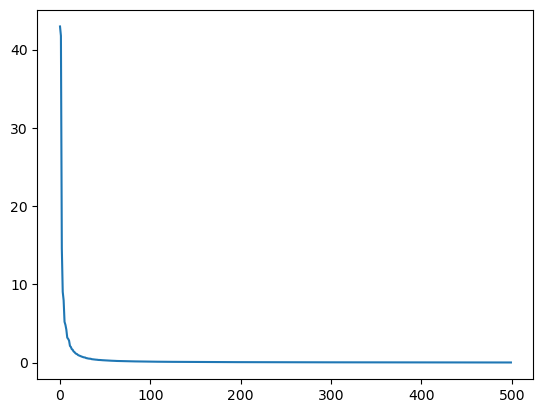

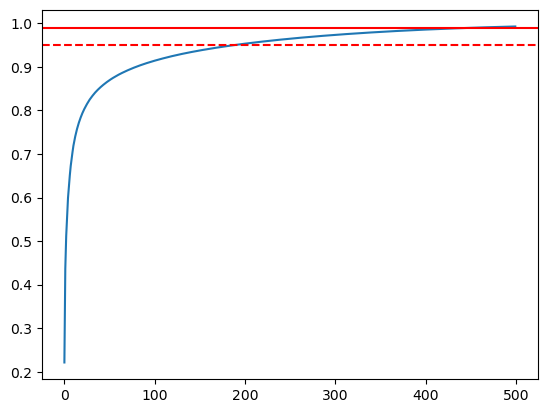

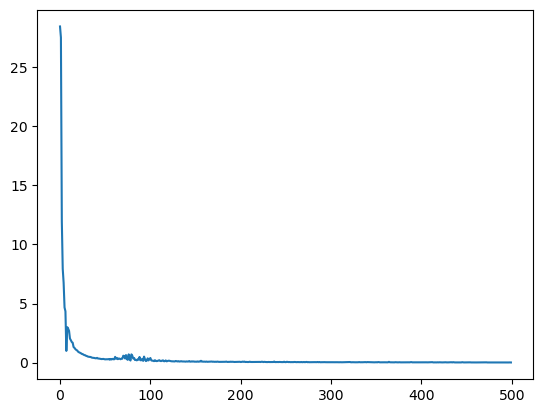

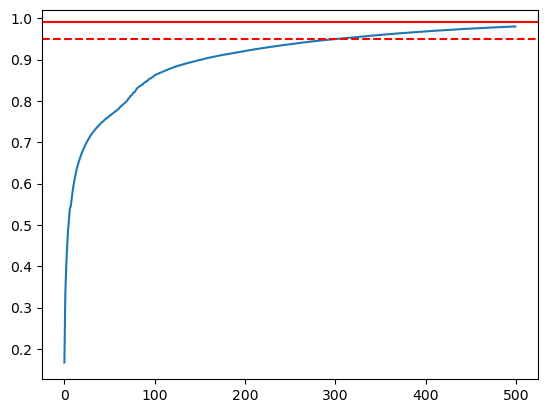

[0.16734968 0.32920718 0.39951298 0.44621405 0.48595417 0.51342827
 0.53897305 0.5448076  0.56246415 0.57936312 0.59516369 0.60712282
 0.61828873 0.62854288 0.6384827  0.64626524 0.65359934 0.66032268
 0.66663362 0.67268435 0.67813406 0.68328086 0.68822139 0.69293652
 0.69728888 0.7015492  0.70551201 0.70924613 0.71289268 0.71621768
 0.71944042 0.72241215 0.72529315 0.7281207  0.73091549 0.73344016
 0.73586596 0.73825757 0.74057081 0.74275865 0.7449095  0.74726265
 0.74929809 0.7513192  0.75326603 0.75517154 0.75693705 0.75874516
 0.7605884  0.76230764 0.76392168 0.7656119  0.76725831 0.7689475
 0.77071395 0.7721828  0.77400139 0.77556524 0.77742138 0.77910693
 0.7807733  0.78362998 0.7855806  0.78791855 0.78962693 0.79167482
 0.79363972 0.79532828 0.79727605 0.79923243 0.80266728 0.80597243
 0.80801388 0.8117728  0.8135037  0.81489176 0.81901219 0.82079804
 0.8218349  0.82594165 0.82935293 0.83140135 0.83371943 0.83499916
 0.83637626 0.83749559 0.83917135 0.84064624 0.84346496 0.84464

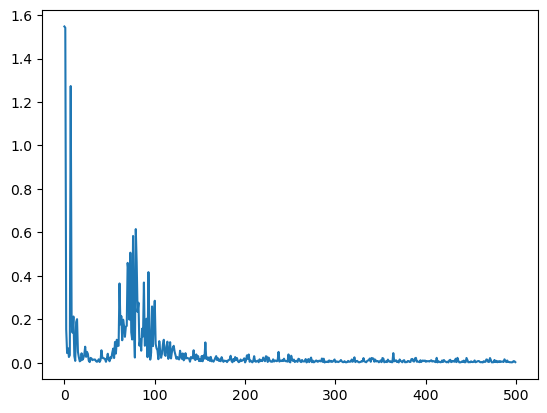

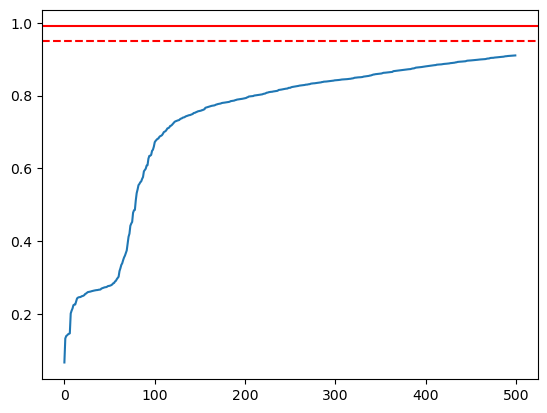

[0.06629949 0.13234119 0.13894148 0.1408772  0.14375914 0.14491833
 0.14644289 0.20100066 0.20887118 0.2148275  0.22396948 0.22531598
 0.2257129  0.23374743 0.24236269 0.24452047 0.24562723 0.24594003
 0.24637329 0.24826712 0.24886744 0.24982122 0.25144501 0.25463441
 0.25583062 0.25800977 0.25977567 0.26019756 0.26036044 0.26134646
 0.26221505 0.26275609 0.26338622 0.26405782 0.26470937 0.26505189
 0.26527056 0.26560537 0.26631698 0.26650009 0.26705351 0.26954097
 0.27057438 0.27149255 0.27238511 0.27311355 0.27333043 0.27420212
 0.27600875 0.27669741 0.2770233  0.27811132 0.27902673 0.28104967
 0.28386397 0.28482405 0.28895053 0.29078642 0.29534761 0.29868911
 0.30207025 0.31772471 0.32530603 0.33451341 0.33897424 0.34749302
 0.35481718 0.3599571  0.36709046 0.37437703 0.39408726 0.41189457
 0.42040904 0.44213036 0.44816531 0.45277811 0.47779106 0.48463098
 0.48568651 0.51205469 0.53183439 0.54186481 0.55372079 0.55712924
 0.56173071 0.56413451 0.57087582 0.5760765  0.59191723 0.5953

IndexError: index 0 is out of bounds for axis 0 with size 0

In [73]:
def stand(x):
    return (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)

max_possible_pca = min(x_train.shape[0], x_train.shape[1])

large_n = 500 # used as the upper limit of number of PCs to use, set such that it's larger than what's required
x_var_required = 0.99
y_var_required = 0.99

# these lines are currently just for testing this cell, comment when running full code
# x_train = stand(x_train)
# y_train = stand(y_train)

### separate PCAs
x_pca = PCA(n_components = large_n)
x_pca.fit(x_train)

plt.plot(x_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(x_pca.explained_variance_ratio_))

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > x_var_required)[0][0]

y_pca = PCA(n_components = large_n)
y_pca.fit(y_train)

plt.plot(y_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(y_pca.explained_variance_ratio_))

m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > y_var_required)[0][0]

print(f'n, m with individually-trained PCAs: {n, m}')

### combined PCA (more features)
combined_pca_full = PCA(n_components = max_possible_pca)
combined_pca = PCA(n_components = large_n)
combined_train = np.concatenate((x_train, y_train), axis = 1)
combined_train_pca_full = combined_pca_full.fit_transform(combined_train)
combined_train_pca = combined_pca.fit_transform(combined_train)
print('does combined pca')

x_pca = PCA(n_components = large_n)
x_pca_full = PCA(n_components = max_possible_pca)
y_pca = PCA(n_components = large_n)
y_pca_full = PCA(n_components = max_possible_pca)

x_pca.components_ = combined_pca.components_[:, :x_train.shape[1]]
x_pca_full.components_ = combined_pca_full.components_[:, :x_train.shape[1]]
x_pca.mean_ = combined_pca.mean_[:x_train.shape[1]]
x_pca_full.mean_ = combined_pca_full.mean_[:x_train.shape[1]]

y_pca.components_ = combined_pca.components_[:, x_train.shape[1]:]
y_pca_full.components_ = combined_pca_full.components_[:, x_train.shape[1]:]
y_pca.mean_ = combined_pca.mean_[x_train.shape[1]:]
y_pca_full.mean_ = combined_pca_full.mean_[x_train.shape[1]:]

def compute_eigenvalues(components, original_data):
    # Reconstruct the covariance matrix from the components
    # `components` are the PCA components for either x_pca or y_pca
    # `original_data` should be x_train or y_train as applicable
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return eigenvalues

def get_total_var(components, original_data):
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return total_variance

x_eigenvalues = compute_eigenvalues(x_pca.components_, x_train - x_pca.mean_)
y_eigenvalues = compute_eigenvalues(y_pca.components_, y_train - y_pca.mean_)

x_pca.explained_variance_ratio_ = x_eigenvalues / get_total_var(x_pca_full.components_, x_train - x_pca_full.mean_)
y_pca.explained_variance_ratio_ = y_eigenvalues / get_total_var(y_pca_full.components_, y_train - y_pca_full.mean_)

x_pca.explained_variance_ = x_eigenvalues
y_pca.explained_variance_ = y_eigenvalues

plt.plot(combined_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(combined_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

plt.plot(x_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(x_pca.explained_variance_ratio_))

plt.plot(y_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(y_pca.explained_variance_ratio_))

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > x_var_required)[0][0]
m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > y_var_required)[0][0]

print(f'n, m with combined PCA (more features): {n, m}')

# combined PCA (more data)
combined_pca = PCA(n_components = large_n)
combined_train = np.concatenate((x_train, y_train), axis = 0)
print(combined_train.shape)
combined_train_pca = combined_pca.fit_transform(combined_train)

plt.plot(combined_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(combined_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

n = np.where(np.cumsum(combined_pca.explained_variance_ratio_) > x_var_required)[0][0]
m = n

print(f'n, m with combined PCA (more data): {n, m}')

# Train

In [87]:
# fitting individual PCAs to x and y

x_train_pca = PCA(n_components=45).fit(x_train)
y_train_pca = PCA(n_components=35).fit(y_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(x_train_pca.components_[int(i/2), :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(y_train_pca.components_[int(i/2), :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(x_train_pca.components_[i, :], y_train_pca.components_[i, :], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(x_train_pca.components_[i, :], y_train_pca.components_[i, :])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

x_train_pca = x_train_pca.transform(x_train)
y_train_pca = y_train_pca.transform(y_train)

for i in range(5):
    plt.figure()
    plt.hist(x_train_pca[:, i], bins=50, label = f'x_train_pca {i+1}', alpha=0.5)
    plt.hist(y_train_pca[:, i], bins=50, label = f'y_train_pca {i+1}', alpha=0.5)
    plt.show()

print('standardising')

for i in range(5):
    x_train_pca_stand_i = (x_train_pca[:, i] - x_train_pca[:, i].mean(axis = 0))/x_train_pca[:, i].std(axis = 0)
    y_train_pca_stand_i = (y_train_pca[:, i] - y_train_pca[:, i].mean(axis = 0))/y_train_pca[:, i].std(axis = 0)
    plt.figure()
    plt.hist(x_train_pca_stand_i, bins=50, label = f'x_train_pca_stand {i+1}', alpha=0.5)
    plt.hist(y_train_pca_stand_i, bins=50, label = f'y_train_pca_stand {i+1}', alpha=0.5)
    plt.show()


KeyboardInterrupt: 

(1000, 1682)


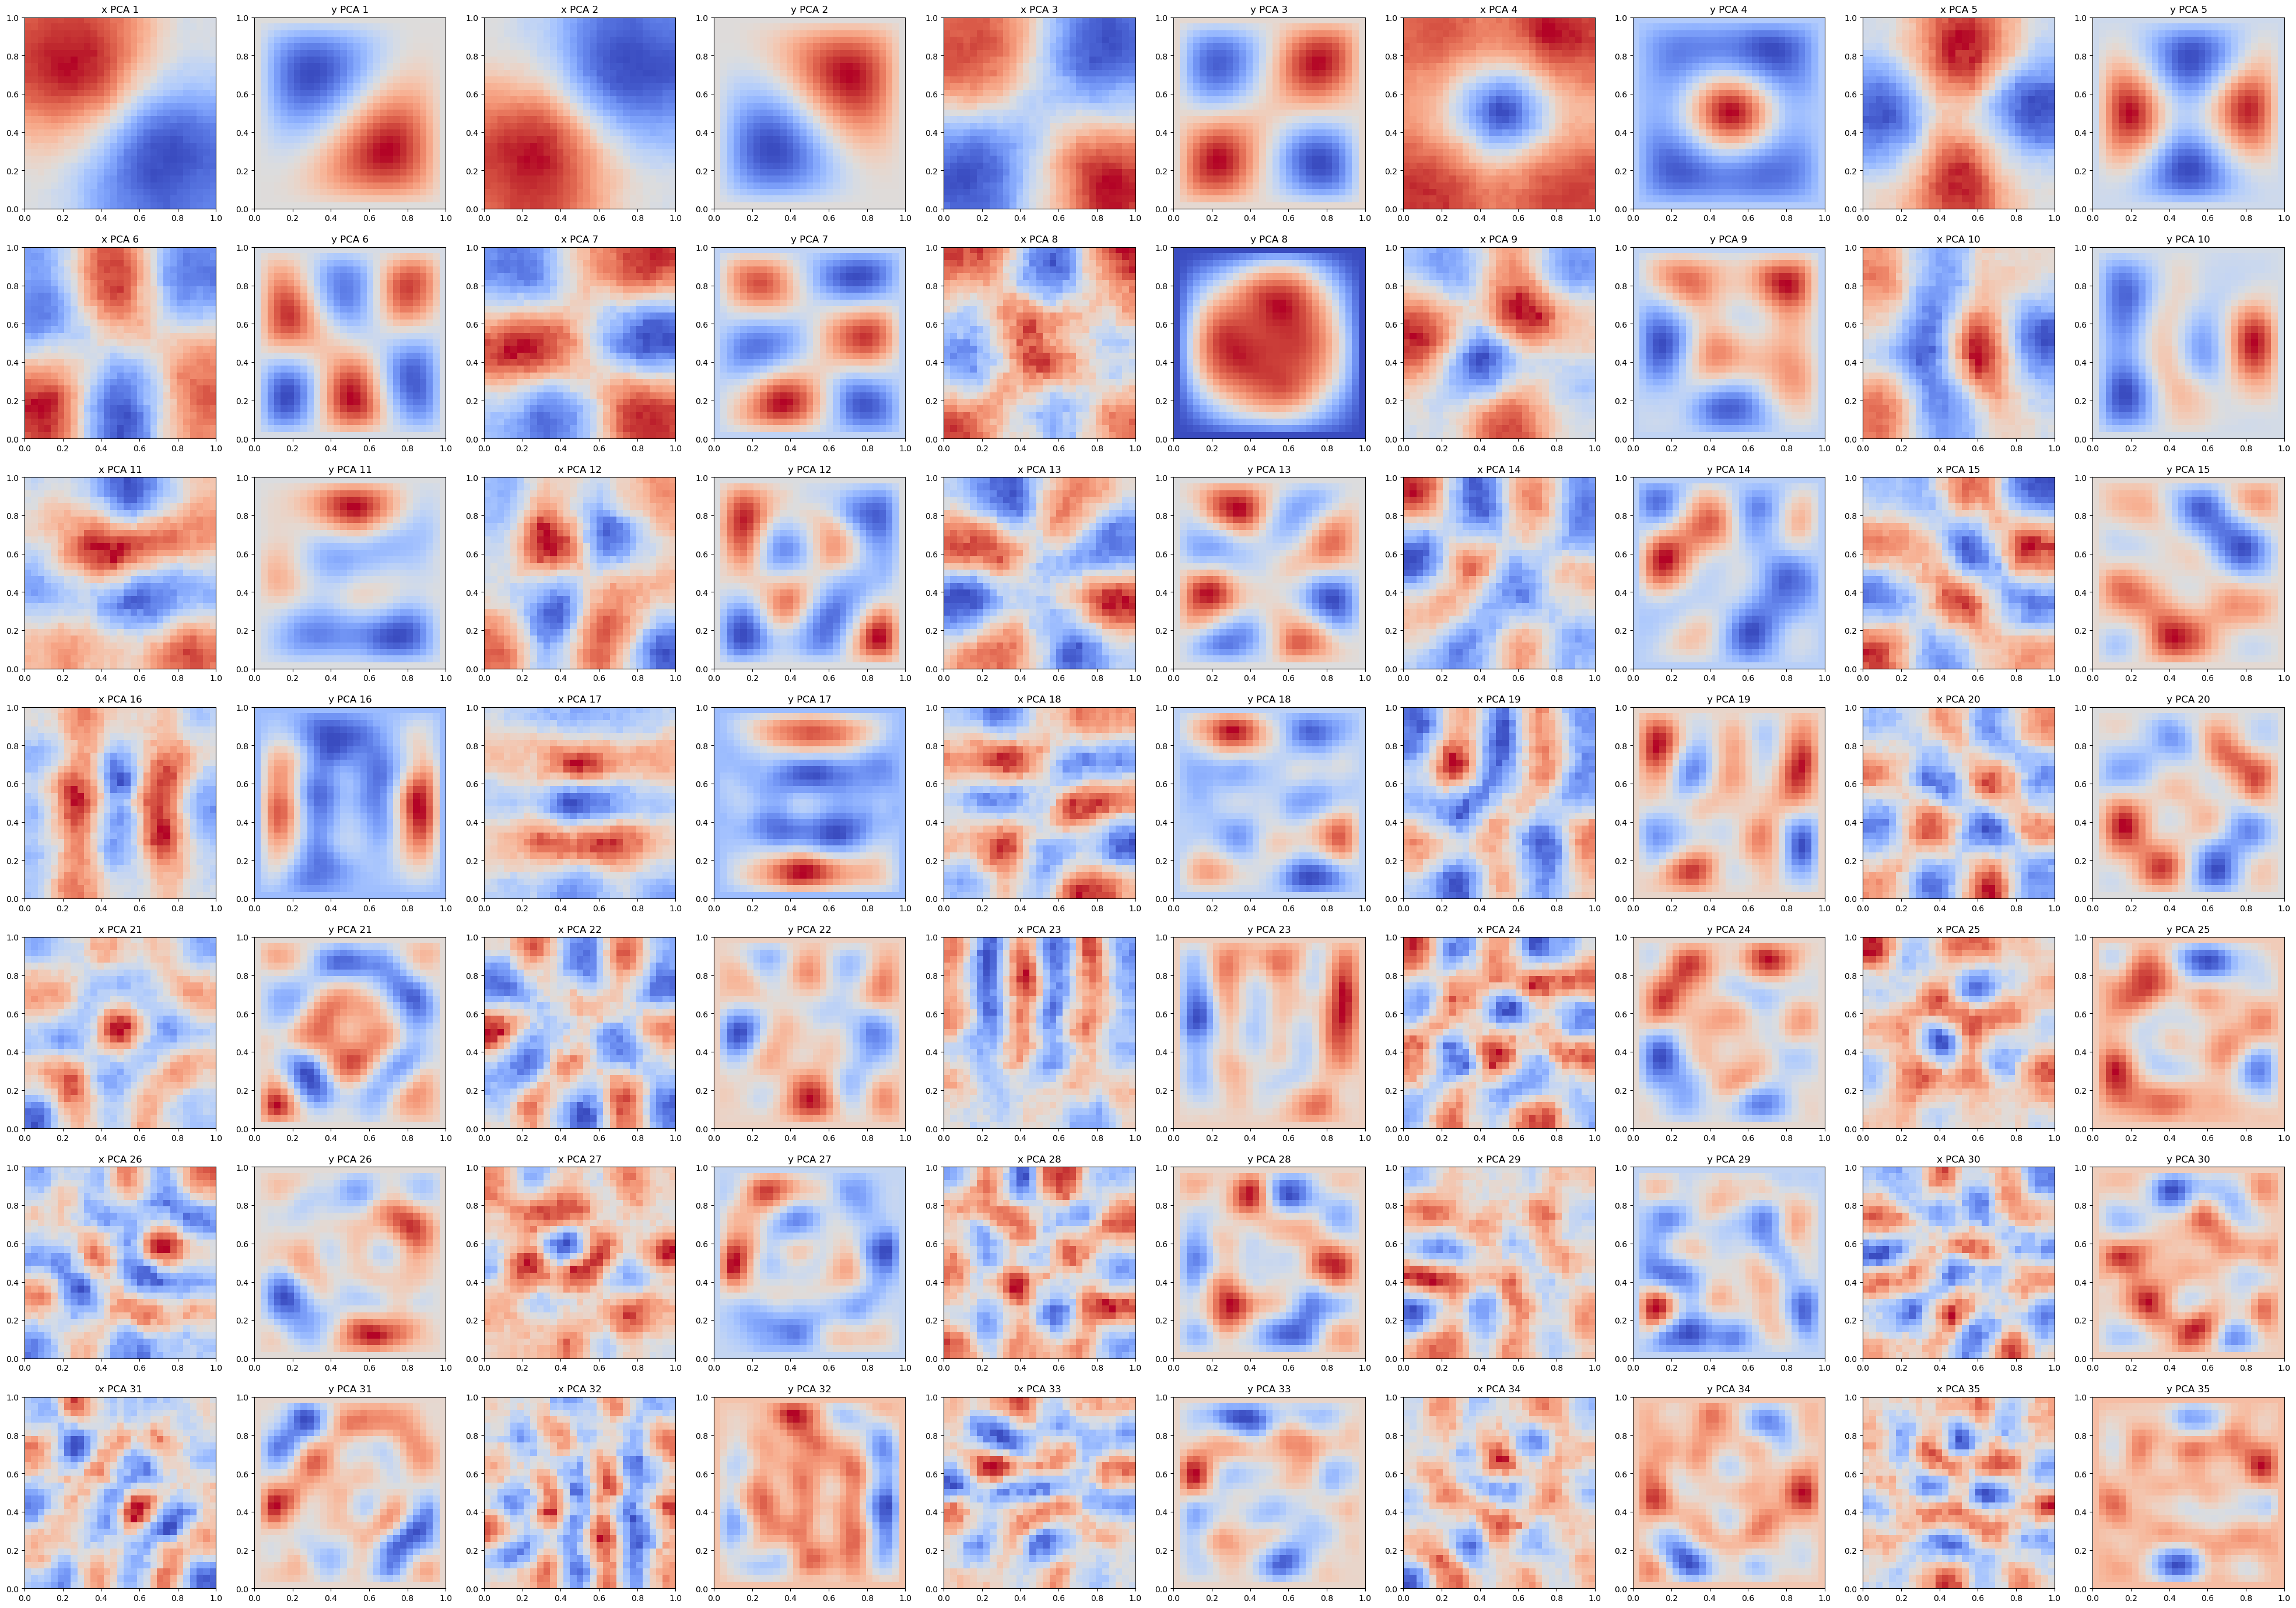

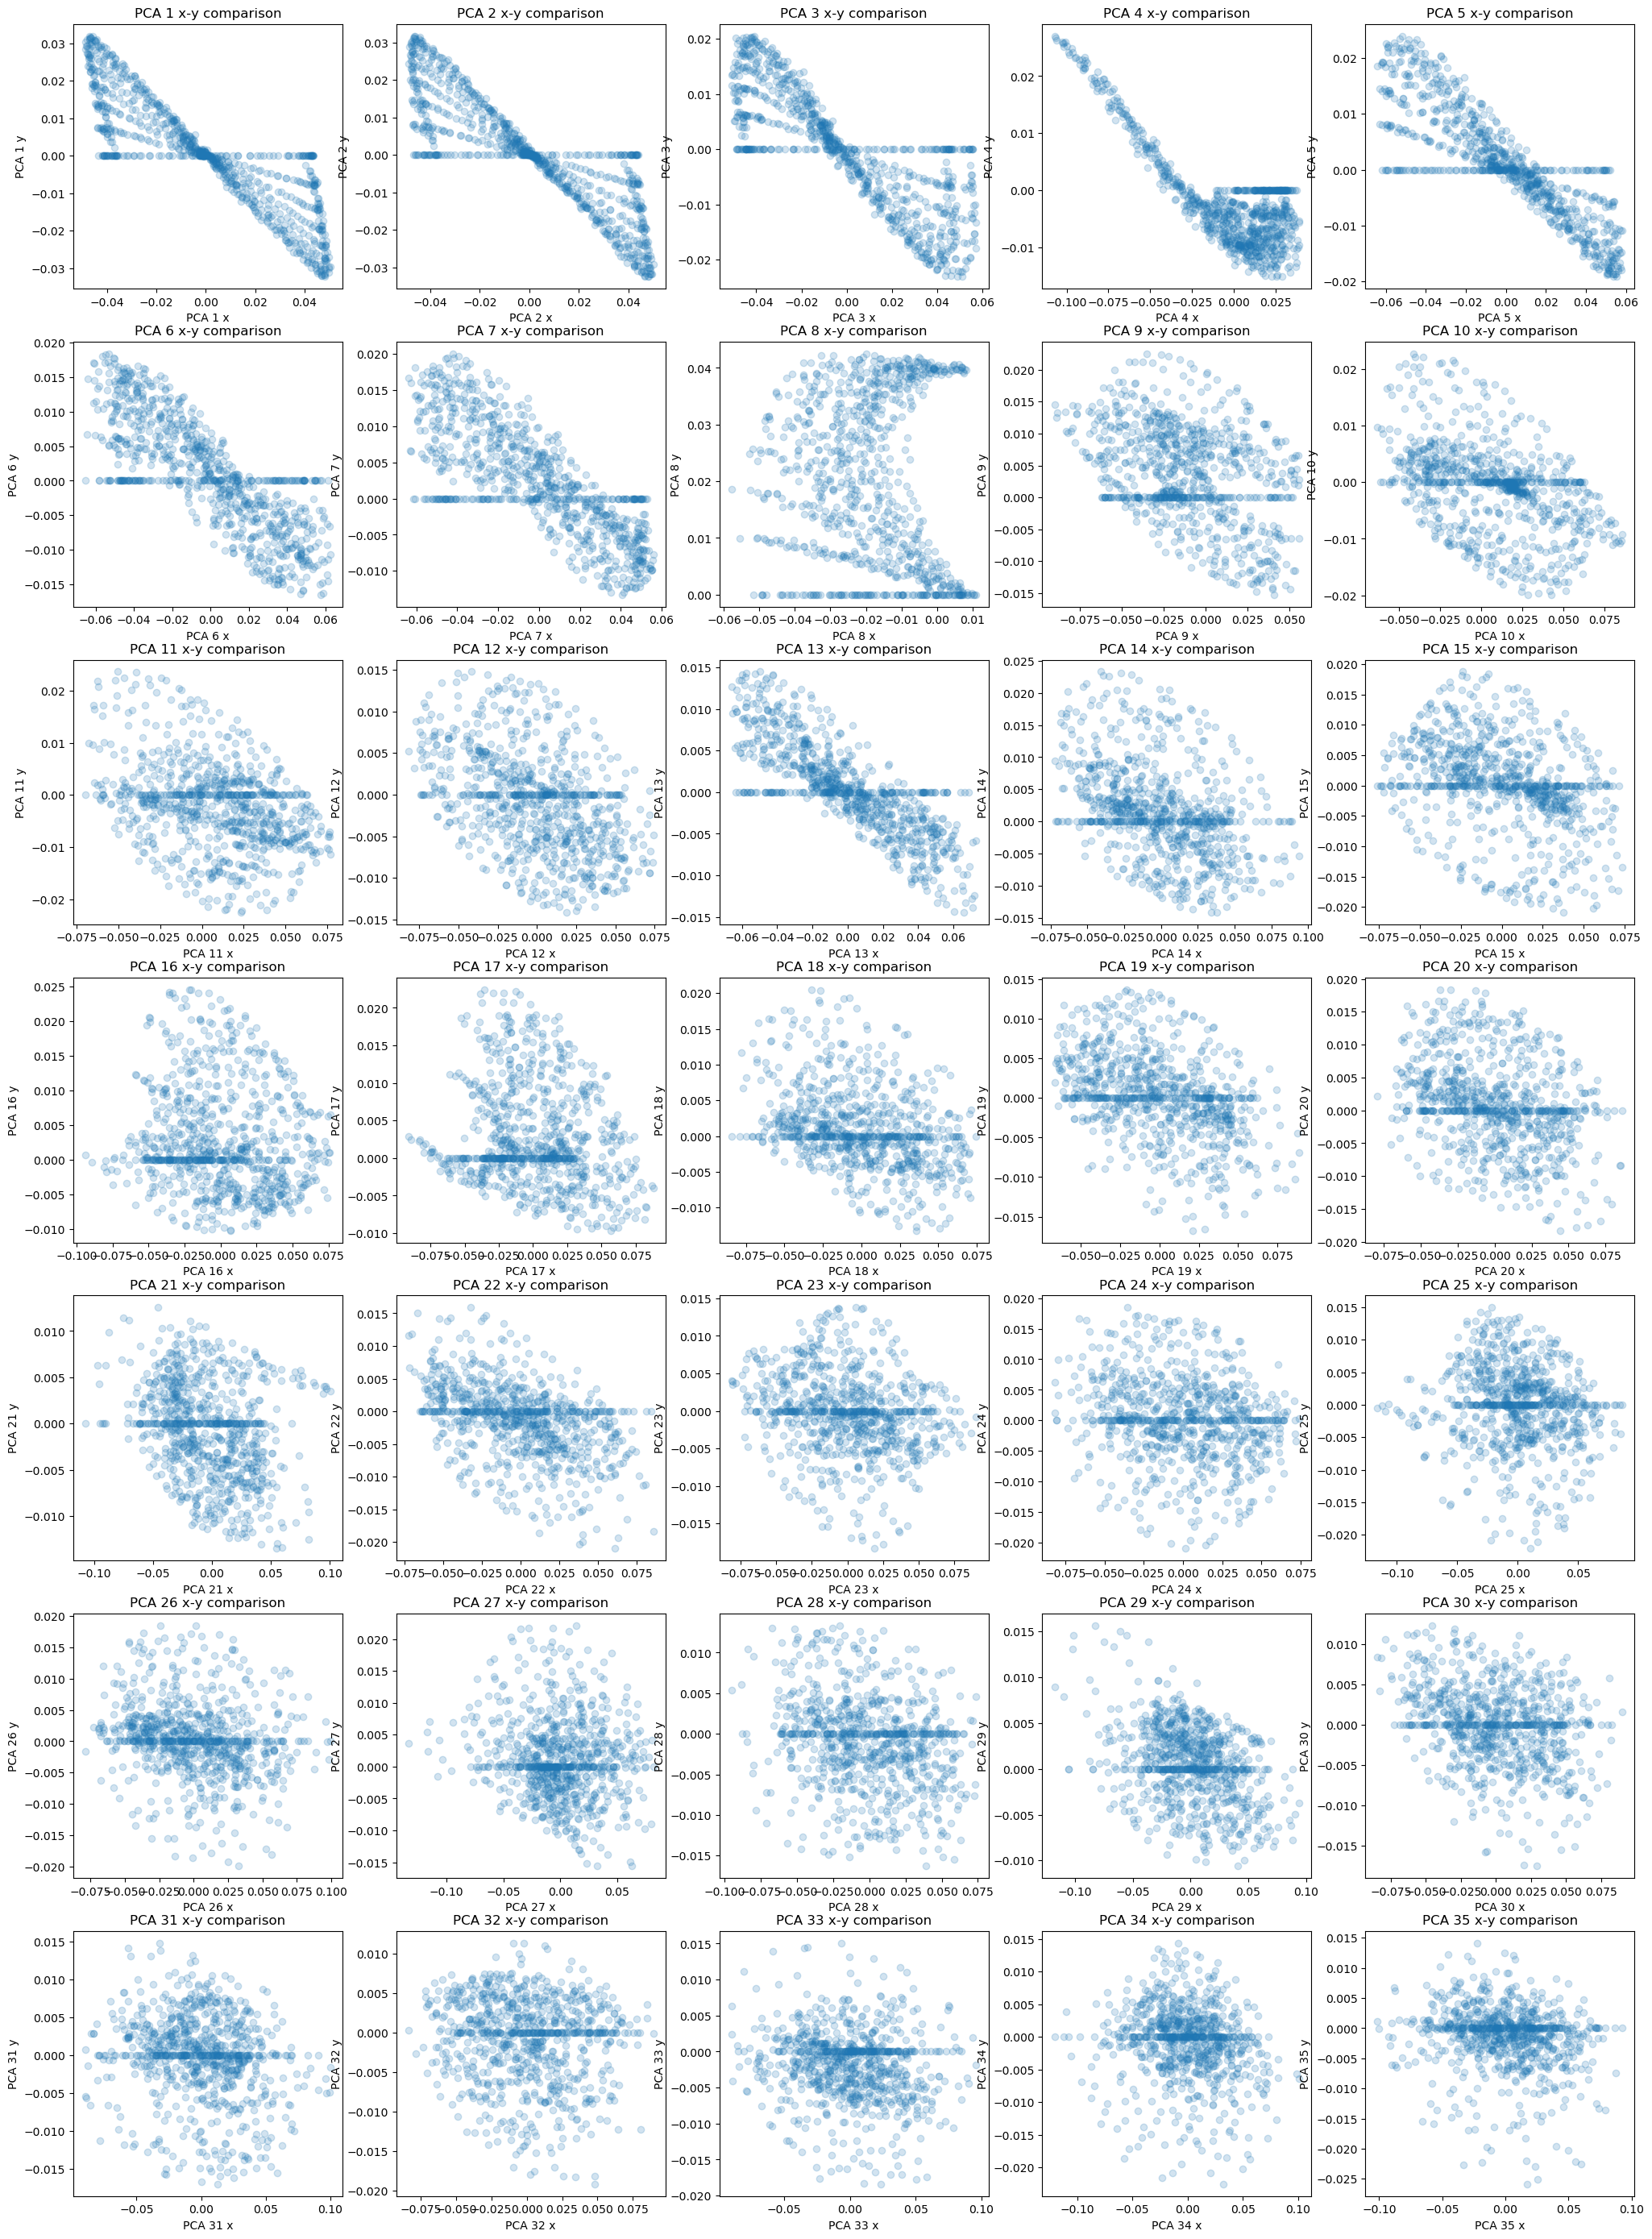

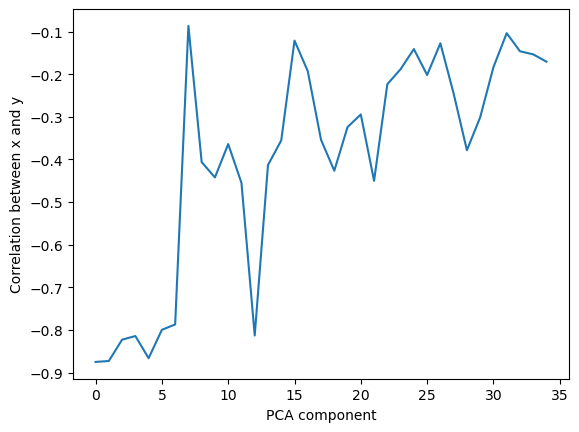

(1000, 45)


In [ ]:
# fitting PCA to combined x and y (more features)

combined_train = np.concatenate((x_train, y_train), axis = 1)
print(combined_train.shape)

combined_train_pca = PCA(n_components=45).fit(combined_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(combined_train_pca.components_[int(i/2), :x_train.shape[1]].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(combined_train_pca.components_[int(i/2), x_train.shape[1]:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(combined_train_pca.components_[i, :x_train.shape[1]], combined_train_pca.components_[i, x_train.shape[1]:], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(combined_train_pca.components_[i, :x_train.shape[1]], combined_train_pca.components_[i, x_train.shape[1]:])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

combined_train_pca = combined_train_pca.transform(combined_train)
print(combined_train_pca.shape)

(2000, 841)


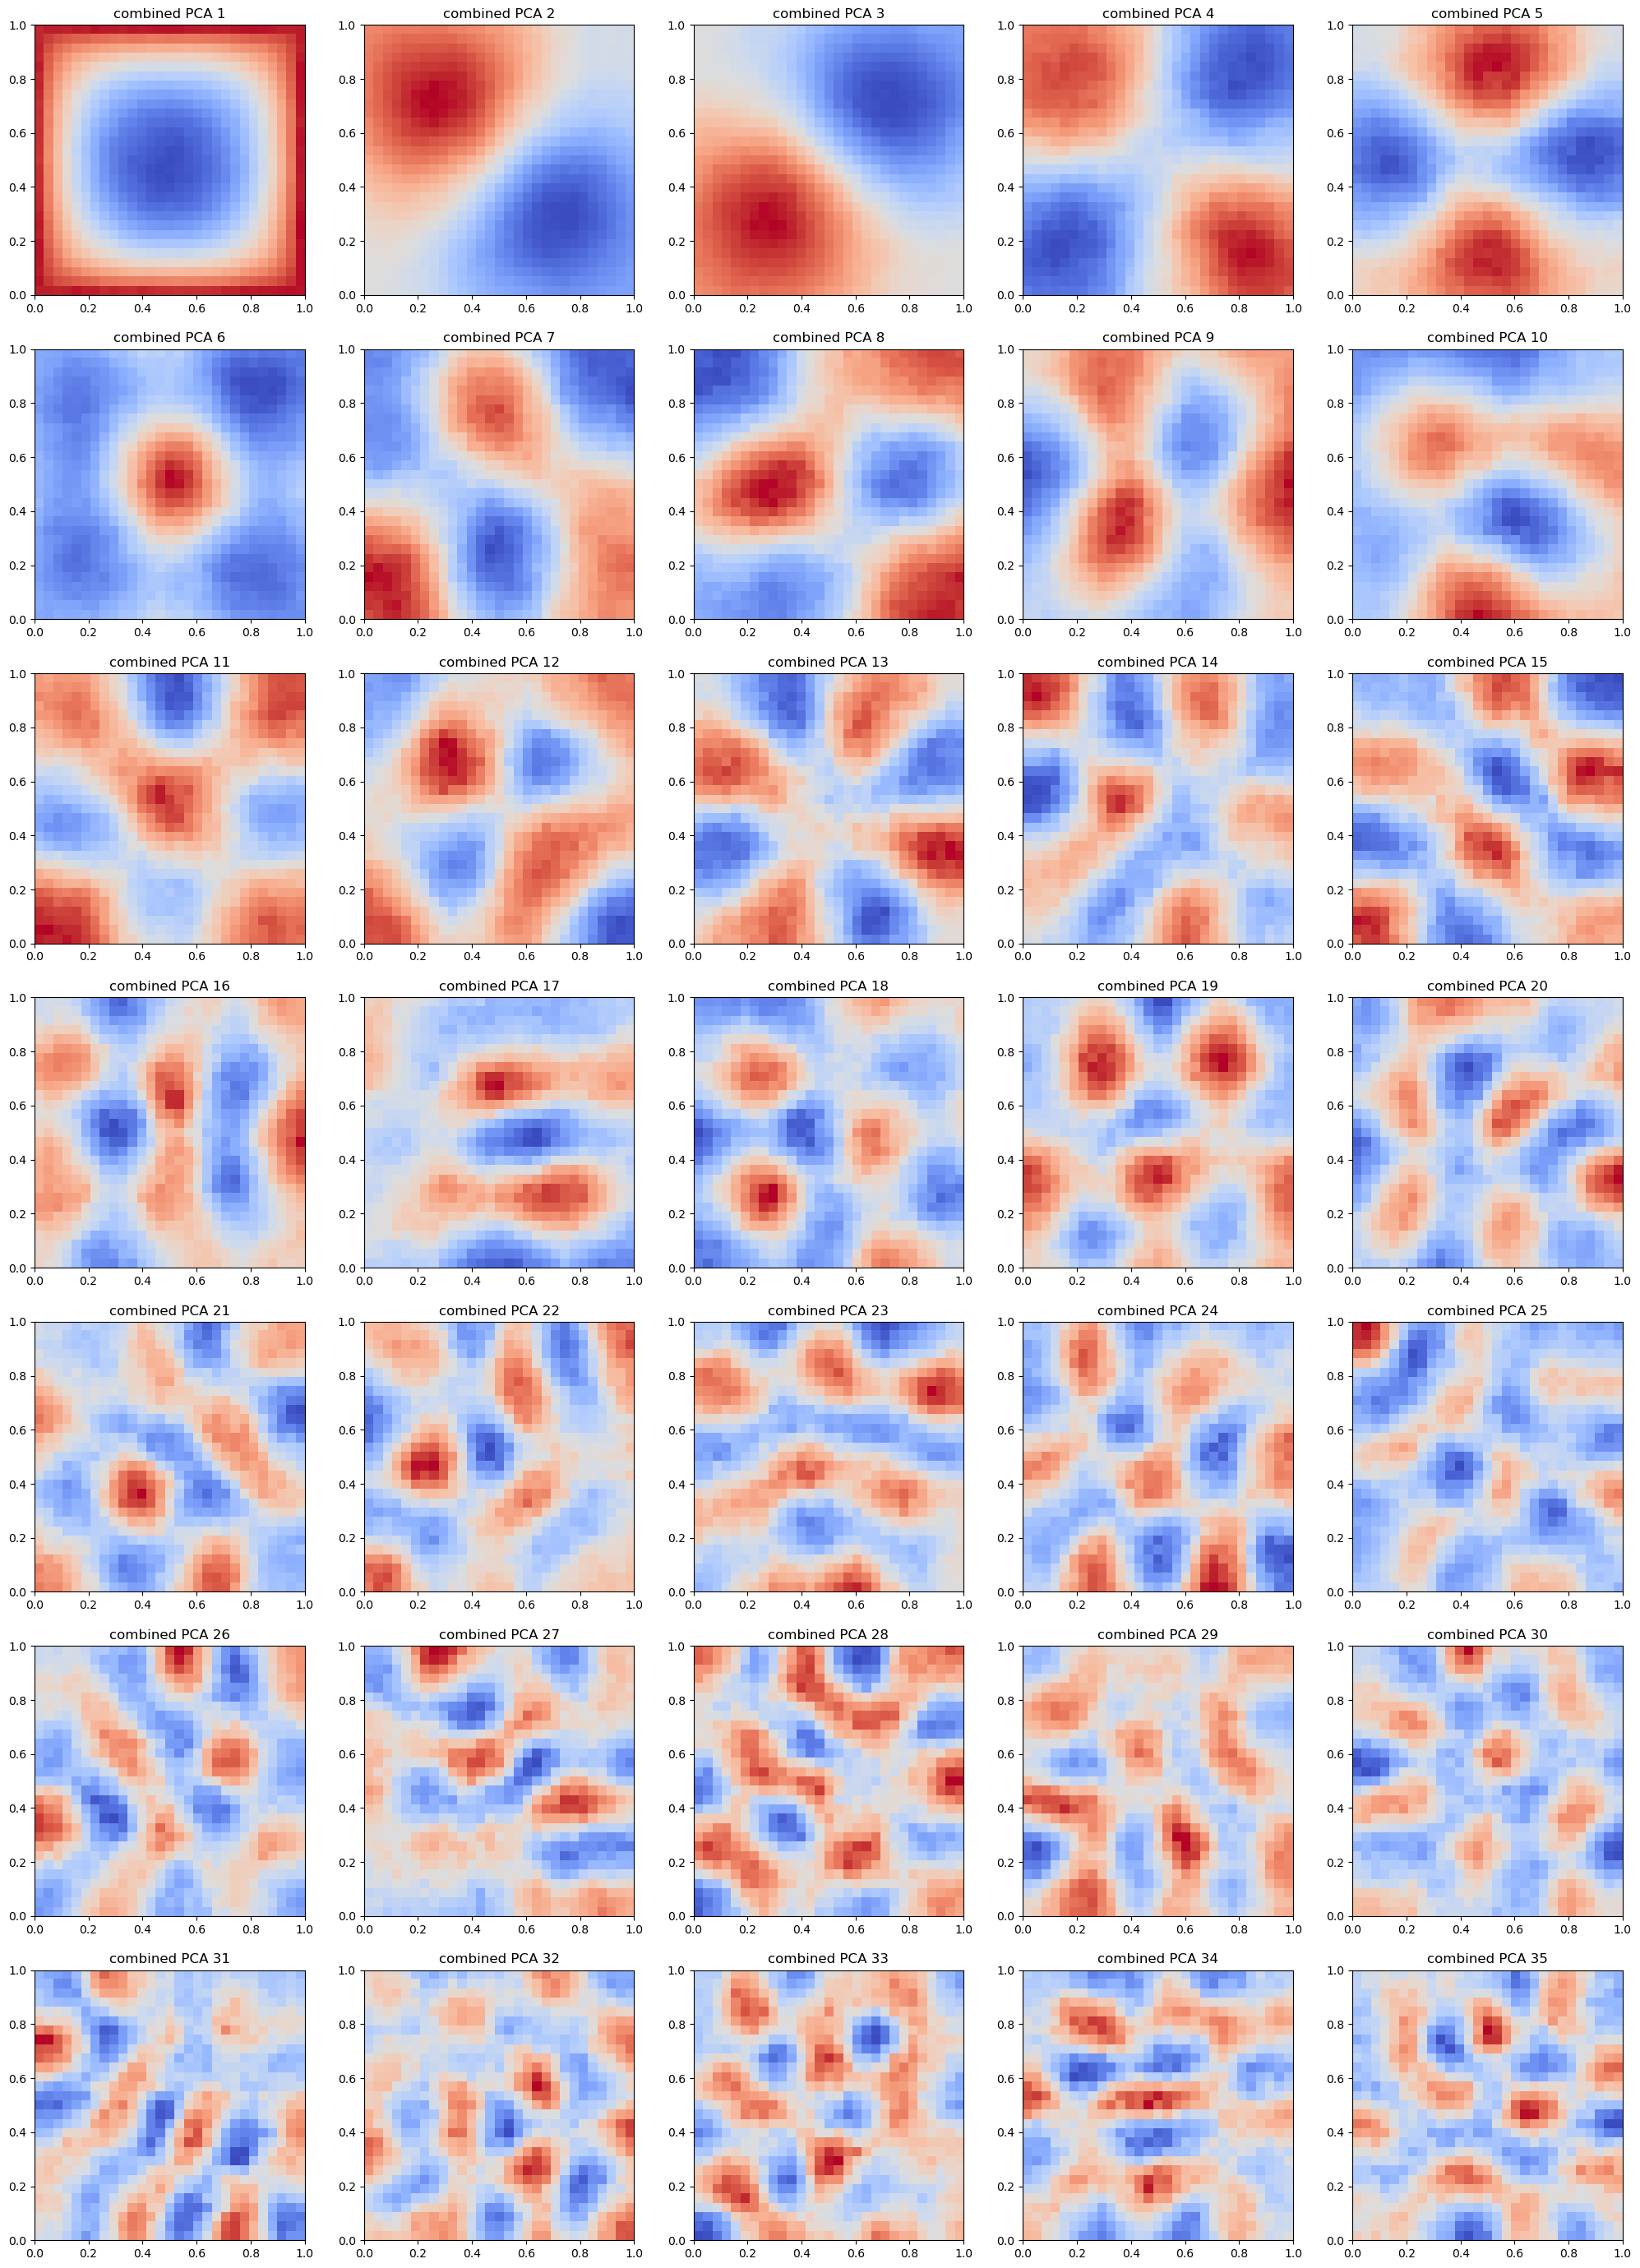

(2000, 45)


In [ ]:
# fit PCA to combined x and y (more data)

combined_train = np.concatenate((x_train, y_train), axis = 0)
print(combined_train.shape)

combined_train_pca = PCA(n_components=45).fit(combined_train)

fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()

for i in range(0, 35):
    ax[i].imshow(combined_train_pca.components_[i, :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i].set_title(f"combined PCA {i+1}")
plt.show()

combined_train_pca = combined_train_pca.transform(combined_train)
print(combined_train_pca.shape)

fitting my custom joint PCA with tunable parameter $\rho$

  0%|          | 0/5 [00:00<?, ?it/s]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

 20%|██        | 1/5 [00:44<02:57, 44.30s/it]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

 40%|████      | 2/5 [01:30<02:17, 45.70s/it]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

 60%|██████    | 3/5 [01:45<01:02, 31.45s/it]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

 80%|████████  | 4/5 [01:56<00:23, 23.24s/it]

initial guess: [ 7.60888805e-02  7.43313765e-02  3.15003067e-01 -4.65747601e-02
 -2.84532430e-02  6.88254109e-02  5.58796527e-02  7.16322645e-02
  2.29392033e-03  7.91439240e-02  2.03997426e-02 -5.62403119e-02
  8.77000652e-03  7.12567439e-02  8.90732911e-02 -7.58117494e-03
 -1.13812175e-01  1.47532825e-02  3.42781962e-02  1.40731773e-01
  9.65092008e-02 -8.86407051e-02  1.45282741e-02  1.50681605e-02
  1.02641282e-01  2.70169049e-02 -1.23773907e-01  4.14553398e-02
 -7.69680026e-02 -3.74656034e-02 -4.72063456e-02 -1.16327191e-02
 -3.08009365e-02 -2.01948678e-02  7.98718834e-02  7.09636242e-02
 -6.64530087e-02  2.51581492e-02  8.56367879e-02 -1.95642015e-02
 -1.26962762e-01  2.77220133e-02 -8.50845957e-02  1.94881127e-04
  1.24681921e-01  1.02407471e-01 -1.62805206e-02 -1.13326092e-01
  5.47431834e-02  8.13711999e-02 -3.38274893e-02  1.02338596e-01
  1.18517754e-02 -8.82668887e-02  3.35781500e-02 -1.00765963e-01
  6.85366367e-02 -1.03682241e-01 -6.64313660e-03 -6.65468193e-02
 -2.675397

100%|██████████| 5/5 [02:00<00:00, 24.11s/it]


(5, 400)


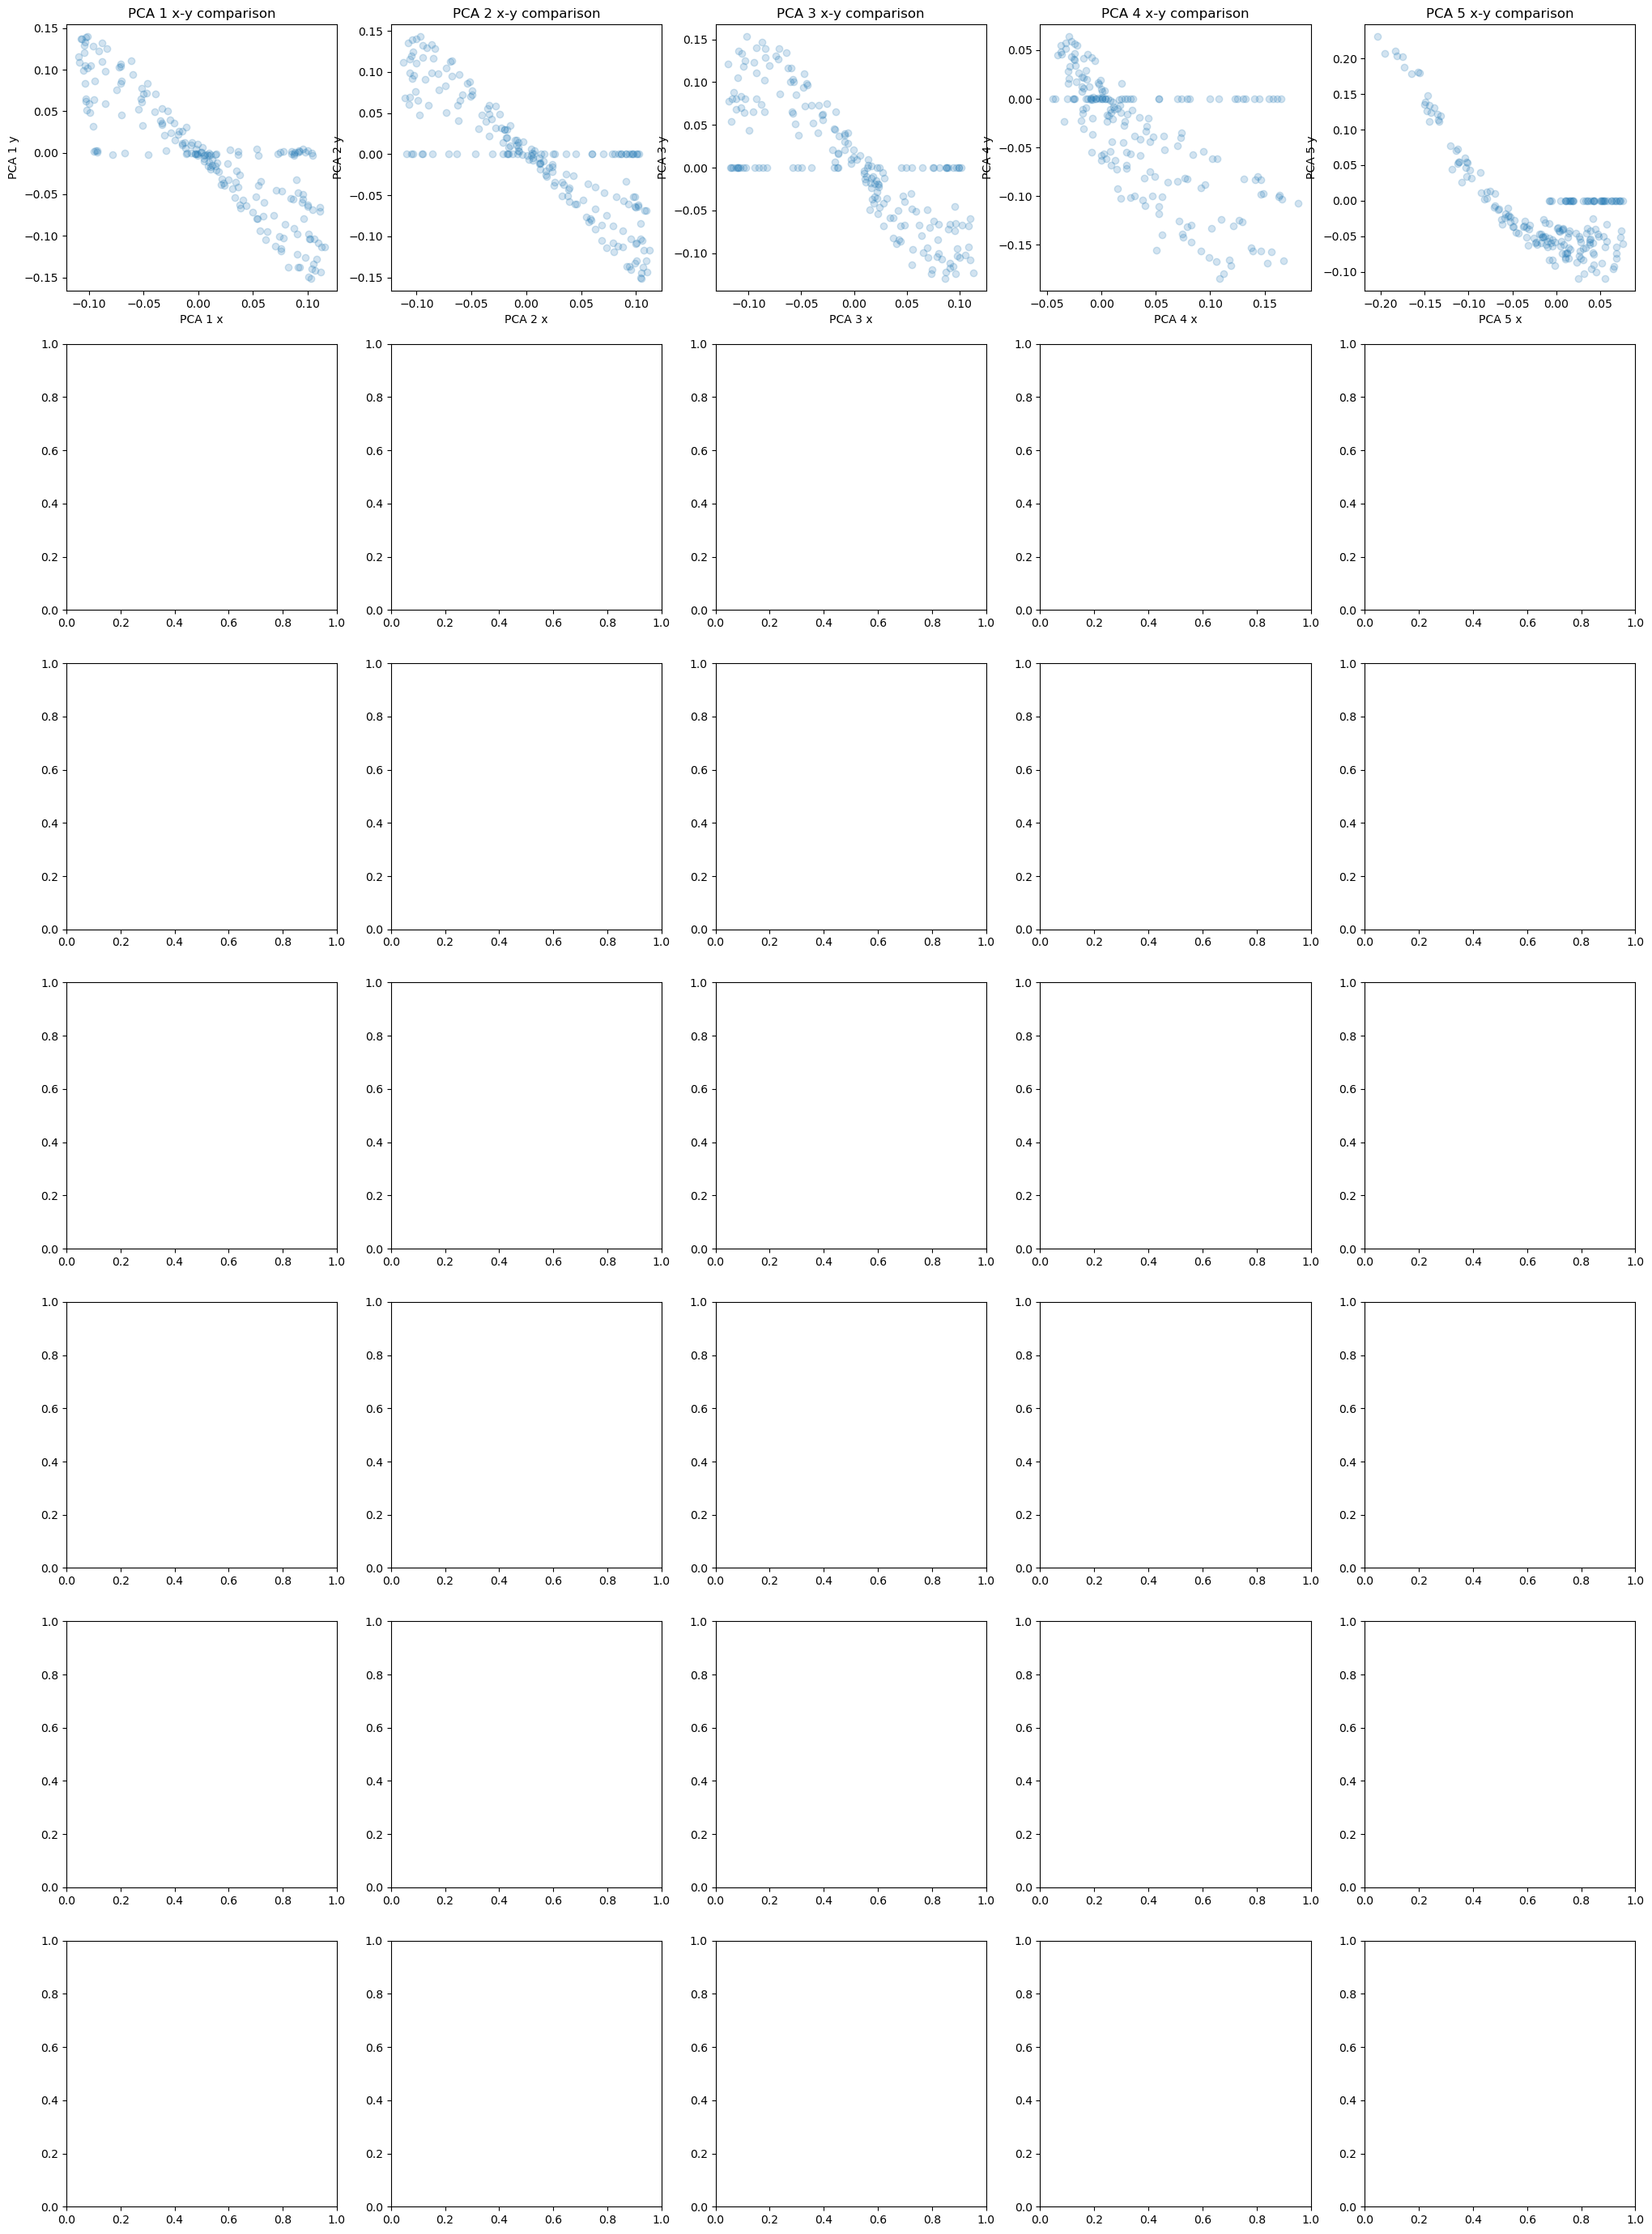

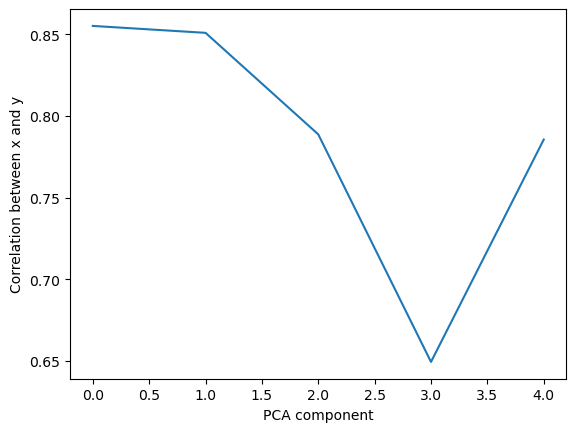

In [ ]:
# parameter
rho = 50
n_components = 5
subset_size = 200
###########

w_opt, result_history, term_history = my_joint_PCA(x_train[:, :subset_size], y_train[:, :subset_size], rho = rho, n_components = n_components)
print(w_opt.shape)

# plotting weights
# fig, ax = plt.subplots(7, 10, figsize=(50, 35))
# ax = ax.flatten()

# for i in range(0, n_components*2, 2):
#     ax[i].imshow(w_opt[int(i/2), :x_train.shape[1]].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
#     ax[i].set_title(f"x PCA {int(i/2)+1}")
#     ax[i+1].imshow(w_opt[int(i/2), x_train.shape[1]:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
#     ax[i+1].set_title(f"y PCA {int(i/2)+1}")
# plt.show()

# plotting weight correlations
corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, n_components):
    ax[i].plot(w_opt[i, :x_train[:, :subset_size].shape[1]], w_opt[i, x_train[:, :subset_size].shape[1]:], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(w_opt[i, :x_train[:, :subset_size].shape[1]], w_opt[i, x_train[:, :subset_size].shape[1]:])[0, 1])
plt.show()

plt.figure()
plt.plot(np.abs(corr_list))
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()


In [ ]:
# for i in range(5):
#     plt.figure()
#     plt.plot(x_train_pca[:, i], y_train_pca[:, i], 'o')
#     plt.show()

In [88]:
## Train

n, m = 50, 50

model = full_model(n = n, m = m, ARD = False, multiinput = True, standardise = True, combine_pca = None)
model.fit(x_train, y_train)

does x pca
does y pca


  0%|          | 0/50 [00:00<?, ?it/s]

[1.]
float64


  2%|▏         | 1/50 [00:16<13:44, 16.83s/it]

Optimization terminated successfully.
         Current function value: -628.520288
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.29027291], dtype=float64), variance=Array([6.65822051], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


  4%|▍         | 2/50 [00:37<15:22, 19.21s/it]

Optimization terminated successfully.
         Current function value: -639.072324
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.474843], dtype=float64), variance=Array([7.84665267], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


  6%|▌         | 3/50 [01:13<20:56, 26.74s/it]

Optimization terminated successfully.
         Current function value: 207.877568
         Iterations: 37
         Function evaluations: 53
         Gradient evaluations: 53
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([17.95181308], dtype=float64), variance=Array([8.19180266], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0961468], dtype=float64))
[2.]
[1.]
[1.]
float64


  8%|▊         | 4/50 [02:00<26:33, 34.63s/it]

Optimization terminated successfully.
         Current function value: -0.083219
         Iterations: 57
         Function evaluations: 64
         Gradient evaluations: 64
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([17.83597931], dtype=float64), variance=Array([7.08056107], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 10%|█         | 5/50 [02:34<25:46, 34.36s/it]

Optimization terminated successfully.
         Current function value: 219.980303
         Iterations: 37
         Function evaluations: 41
         Gradient evaluations: 41
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([16.02200197], dtype=float64), variance=Array([7.26347376], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01014233], dtype=float64))
[2.]
[1.]
[1.]
float64


 12%|█▏        | 6/50 [03:06<24:45, 33.76s/it]

Optimization terminated successfully.
         Current function value: 136.493547
         Iterations: 31
         Function evaluations: 43
         Gradient evaluations: 43
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([16.92040039], dtype=float64), variance=Array([6.92760844], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04860983], dtype=float64))
[2.]
[1.]
[1.]
float64


 14%|█▍        | 7/50 [03:36<23:15, 32.45s/it]

Optimization terminated successfully.
         Current function value: 262.675596
         Iterations: 27
         Function evaluations: 39
         Gradient evaluations: 39
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([16.04101201], dtype=float64), variance=Array([7.18333319], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.05958201], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 16%|█▌        | 8/50 [04:38<29:25, 42.02s/it]

         Current function value: 321.112020
         Iterations: 36
         Function evaluations: 109
         Gradient evaluations: 97
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([15.71851742], dtype=float64), variance=Array([7.81916953], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04708426], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 18%|█▊        | 9/50 [05:20<28:41, 41.99s/it]

         Current function value: 535.620199
         Iterations: 31
         Function evaluations: 69
         Gradient evaluations: 57
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([12.16333736], dtype=float64), variance=Array([4.63231463], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.05667031], dtype=float64))
[2.]
[1.]
[1.]
float64


 20%|██        | 10/50 [05:59<27:16, 40.92s/it]

Optimization terminated successfully.
         Current function value: 601.150747
         Iterations: 39
         Function evaluations: 53
         Gradient evaluations: 53
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([12.50884439], dtype=float64), variance=Array([5.94917675], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04916047], dtype=float64))
[2.]
[1.]
[1.]
float64


 22%|██▏       | 11/50 [06:26<23:57, 36.86s/it]

Optimization terminated successfully.
         Current function value: 433.567100
         Iterations: 28
         Function evaluations: 38
         Gradient evaluations: 38
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([13.45779735], dtype=float64), variance=Array([5.32975501], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06442464], dtype=float64))
[2.]
[1.]
[1.]
float64


 24%|██▍       | 12/50 [06:53<21:26, 33.87s/it]

Optimization terminated successfully.
         Current function value: 659.586288
         Iterations: 30
         Function evaluations: 36
         Gradient evaluations: 36
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.89431491], dtype=float64), variance=Array([4.12811193], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.02943646], dtype=float64))
[2.]
[1.]
[1.]
float64


 26%|██▌       | 13/50 [07:18<19:11, 31.13s/it]

Optimization terminated successfully.
         Current function value: 562.860744
         Iterations: 28
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([11.91401104], dtype=float64), variance=Array([4.48142513], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06532567], dtype=float64))
[2.]
[1.]
[1.]
float64


 28%|██▊       | 14/50 [07:41<17:12, 28.68s/it]

Optimization terminated successfully.
         Current function value: 664.283113
         Iterations: 25
         Function evaluations: 32
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([11.52534121], dtype=float64), variance=Array([4.57963914], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.1045456], dtype=float64))
[2.]
[1.]
[1.]
float64


 30%|███       | 15/50 [08:02<15:17, 26.22s/it]

Optimization terminated successfully.
         Current function value: 741.418172
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.66821172], dtype=float64), variance=Array([2.81857856], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.12521953], dtype=float64))
[2.]
[1.]
[1.]
float64


 32%|███▏      | 16/50 [08:25<14:21, 25.34s/it]

Optimization terminated successfully.
         Current function value: 696.477386
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.30679851], dtype=float64), variance=Array([3.42438037], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.08605087], dtype=float64))
[2.]
[1.]
[1.]
float64


 34%|███▍      | 17/50 [08:46<13:15, 24.11s/it]

Optimization terminated successfully.
         Current function value: 686.485070
         Iterations: 22
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.74666455], dtype=float64), variance=Array([3.47120884], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.13797681], dtype=float64))
[2.]
[1.]
[1.]
float64


 36%|███▌      | 18/50 [09:11<12:56, 24.27s/it]

Optimization terminated successfully.
         Current function value: 794.448605
         Iterations: 24
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.4867399], dtype=float64), variance=Array([4.15252998], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.13138587], dtype=float64))
[2.]
[1.]
[1.]
float64


 38%|███▊      | 19/50 [09:35<12:26, 24.08s/it]

Optimization terminated successfully.
         Current function value: 781.099843
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.08946846], dtype=float64), variance=Array([3.39877202], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.14822386], dtype=float64))
[2.]
[1.]
[1.]
float64


 40%|████      | 20/50 [09:54<11:23, 22.78s/it]

Optimization terminated successfully.
         Current function value: 782.097323
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.61996822], dtype=float64), variance=Array([2.62104853], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.18821285], dtype=float64))
[2.]
[1.]
[1.]
float64


 42%|████▏     | 21/50 [10:15<10:39, 22.04s/it]

Optimization terminated successfully.
         Current function value: 822.447264
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.40932118], dtype=float64), variance=Array([3.15706138], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.24674662], dtype=float64))
[2.]
[1.]
[1.]
float64


 44%|████▍     | 22/50 [10:34<09:57, 21.33s/it]

Optimization terminated successfully.
         Current function value: 920.505551
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.87372524], dtype=float64), variance=Array([3.30399564], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.26414696], dtype=float64))
[2.]
[1.]
[1.]
float64


 46%|████▌     | 23/50 [10:54<09:21, 20.78s/it]

Optimization terminated successfully.
         Current function value: 956.061144
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.1969899], dtype=float64), variance=Array([2.24290627], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.2180717], dtype=float64))
[2.]
[1.]
[1.]
float64


 48%|████▊     | 24/50 [11:12<08:36, 19.86s/it]

Optimization terminated successfully.
         Current function value: 958.756286
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.10476637], dtype=float64), variance=Array([2.25776473], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.20055899], dtype=float64))
[2.]
[1.]
[1.]
float64


 50%|█████     | 25/50 [11:31<08:11, 19.65s/it]

Optimization terminated successfully.
         Current function value: 992.659720
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.86780049], dtype=float64), variance=Array([2.64804418], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.29017787], dtype=float64))
[2.]
[1.]
[1.]
float64


 52%|█████▏    | 26/50 [11:50<07:46, 19.43s/it]

Optimization terminated successfully.
         Current function value: 927.190388
         Iterations: 19
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.71157843], dtype=float64), variance=Array([2.63984766], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.19895026], dtype=float64))
[2.]
[1.]
[1.]
float64


 54%|█████▍    | 27/50 [12:07<07:09, 18.69s/it]

Optimization terminated successfully.
         Current function value: 1071.515823
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.20734901], dtype=float64), variance=Array([1.78429599], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.28292479], dtype=float64))
[2.]
[1.]
[1.]
float64


 56%|█████▌    | 28/50 [12:25<06:50, 18.68s/it]

Optimization terminated successfully.
         Current function value: 1104.127988
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.53913578], dtype=float64), variance=Array([2.185743], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.28851713], dtype=float64))
[2.]
[1.]
[1.]
float64


 58%|█████▊    | 29/50 [12:46<06:45, 19.31s/it]

Optimization terminated successfully.
         Current function value: 1081.894439
         Iterations: 22
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.68675013], dtype=float64), variance=Array([2.2101812], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.28297492], dtype=float64))
[2.]
[1.]
[1.]
float64


 60%|██████    | 30/50 [13:05<06:26, 19.32s/it]

Optimization terminated successfully.
         Current function value: 1129.228181
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.09913564], dtype=float64), variance=Array([1.9099595], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.3020797], dtype=float64))
[2.]
[1.]
[1.]
float64


 62%|██████▏   | 31/50 [13:24<05:59, 18.94s/it]

Optimization terminated successfully.
         Current function value: 1159.239562
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.42388202], dtype=float64), variance=Array([1.61038306], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.28867394], dtype=float64))
[2.]
[1.]
[1.]
float64


 64%|██████▍   | 32/50 [13:44<05:50, 19.47s/it]

Optimization terminated successfully.
         Current function value: 1187.814844
         Iterations: 21
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.63180299], dtype=float64), variance=Array([1.54526506], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.39015211], dtype=float64))
[2.]
[1.]
[1.]
float64


 66%|██████▌   | 33/50 [14:03<05:25, 19.15s/it]

Optimization terminated successfully.
         Current function value: 1080.490141
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.96113081], dtype=float64), variance=Array([2.162054], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.33488417], dtype=float64))
[2.]
[1.]
[1.]
float64


 68%|██████▊   | 34/50 [14:24<05:15, 19.73s/it]

Optimization terminated successfully.
         Current function value: 1054.731354
         Iterations: 22
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.60142393], dtype=float64), variance=Array([2.36997934], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.35720187], dtype=float64))
[2.]
[1.]
[1.]
float64


 70%|███████   | 35/50 [14:44<04:56, 19.79s/it]

Optimization terminated successfully.
         Current function value: 1179.832991
         Iterations: 20
         Function evaluations: 27
         Gradient evaluations: 27
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.74592801], dtype=float64), variance=Array([1.7100143], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.35425628], dtype=float64))
[2.]
[1.]
[1.]
float64


 72%|███████▏  | 36/50 [15:05<04:43, 20.25s/it]

Optimization terminated successfully.
         Current function value: 1237.589064
         Iterations: 21
         Function evaluations: 29
         Gradient evaluations: 29
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.97694089], dtype=float64), variance=Array([1.4708998], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.35378918], dtype=float64))
[2.]
[1.]
[1.]
float64


 74%|███████▍  | 37/50 [15:27<04:30, 20.81s/it]

Optimization terminated successfully.
         Current function value: 1282.914848
         Iterations: 20
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.69868953], dtype=float64), variance=Array([1.30344132], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.42741596], dtype=float64))
[2.]
[1.]
[1.]
float64


 76%|███████▌  | 38/50 [15:48<04:09, 20.79s/it]

Optimization terminated successfully.
         Current function value: 1246.698550
         Iterations: 19
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.97753333], dtype=float64), variance=Array([1.38791115], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.39879616], dtype=float64))
[2.]
[1.]
[1.]
float64


 78%|███████▊  | 39/50 [16:09<03:50, 20.94s/it]

Optimization terminated successfully.
         Current function value: 1276.715771
         Iterations: 21
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.93042404], dtype=float64), variance=Array([1.4020794], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.42698725], dtype=float64))
[2.]
[1.]
[1.]
float64


 80%|████████  | 40/50 [16:32<03:35, 21.50s/it]

Optimization terminated successfully.
         Current function value: 1239.324957
         Iterations: 21
         Function evaluations: 32
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.20453396], dtype=float64), variance=Array([1.60706568], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.3577057], dtype=float64))
[2.]
[1.]
[1.]
float64


 82%|████████▏ | 41/50 [16:52<03:09, 21.10s/it]

Optimization terminated successfully.
         Current function value: 1272.994373
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.74365462], dtype=float64), variance=Array([1.39514577], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.3850852], dtype=float64))
[2.]
[1.]
[1.]
float64


 84%|████████▍ | 42/50 [17:10<02:42, 20.27s/it]

Optimization terminated successfully.
         Current function value: 1219.763352
         Iterations: 18
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.25311941], dtype=float64), variance=Array([1.53703127], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.36417415], dtype=float64))
[2.]
[1.]
[1.]
float64


 86%|████████▌ | 43/50 [17:34<02:27, 21.13s/it]

Optimization terminated successfully.
         Current function value: 1257.967093
         Iterations: 23
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.32781582], dtype=float64), variance=Array([1.4812273], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.44720822], dtype=float64))
[2.]
[1.]
[1.]
float64


 88%|████████▊ | 44/50 [17:53<02:04, 20.72s/it]

Optimization terminated successfully.
         Current function value: 1247.414217
         Iterations: 20
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.16965515], dtype=float64), variance=Array([1.3106314], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.45921785], dtype=float64))
[2.]
[1.]
[1.]
float64


 90%|█████████ | 45/50 [18:14<01:44, 20.81s/it]

Optimization terminated successfully.
         Current function value: 1312.767814
         Iterations: 21
         Function evaluations: 29
         Gradient evaluations: 29
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.99537686], dtype=float64), variance=Array([1.18659454], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.37048573], dtype=float64))
[2.]
[1.]
[1.]
float64


 92%|█████████▏| 46/50 [18:36<01:24, 21.15s/it]

Optimization terminated successfully.
         Current function value: 1274.002518
         Iterations: 22
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.60030218], dtype=float64), variance=Array([1.48966151], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.50568736], dtype=float64))
[2.]
[1.]
[1.]
float64


 94%|█████████▍| 47/50 [18:56<01:02, 20.86s/it]

Optimization terminated successfully.
         Current function value: 1297.920693
         Iterations: 20
         Function evaluations: 29
         Gradient evaluations: 29
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.32478518], dtype=float64), variance=Array([1.17951531], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.42708263], dtype=float64))
[2.]
[1.]
[1.]
float64


 96%|█████████▌| 48/50 [19:19<00:42, 21.42s/it]

Optimization terminated successfully.
         Current function value: 1289.991717
         Iterations: 23
         Function evaluations: 32
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.81175022], dtype=float64), variance=Array([1.20248097], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.49388388], dtype=float64))
[2.]
[1.]
[1.]
float64


 98%|█████████▊| 49/50 [19:39<00:20, 20.82s/it]

Optimization terminated successfully.
         Current function value: 1345.733748
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.90716344], dtype=float64), variance=Array([1.09747047], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.45662944], dtype=float64))
[2.]
[1.]
[1.]
float64


100%|██████████| 50/50 [20:01<00:00, 24.03s/it]

Optimization terminated successfully.
         Current function value: 1349.653815
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.63826424], dtype=float64), variance=Array([1.21864714], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.31294037], dtype=float64))
[2.]
[1.]


In [75]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


(1000, 841, 6)
median relative L2 (train data): 0.016211295176101356
mean relative L2 (train data): 0.016174846480280572


(1000, 841, 6)


IndexError: index 45 is out of bounds for axis 0 with size 45

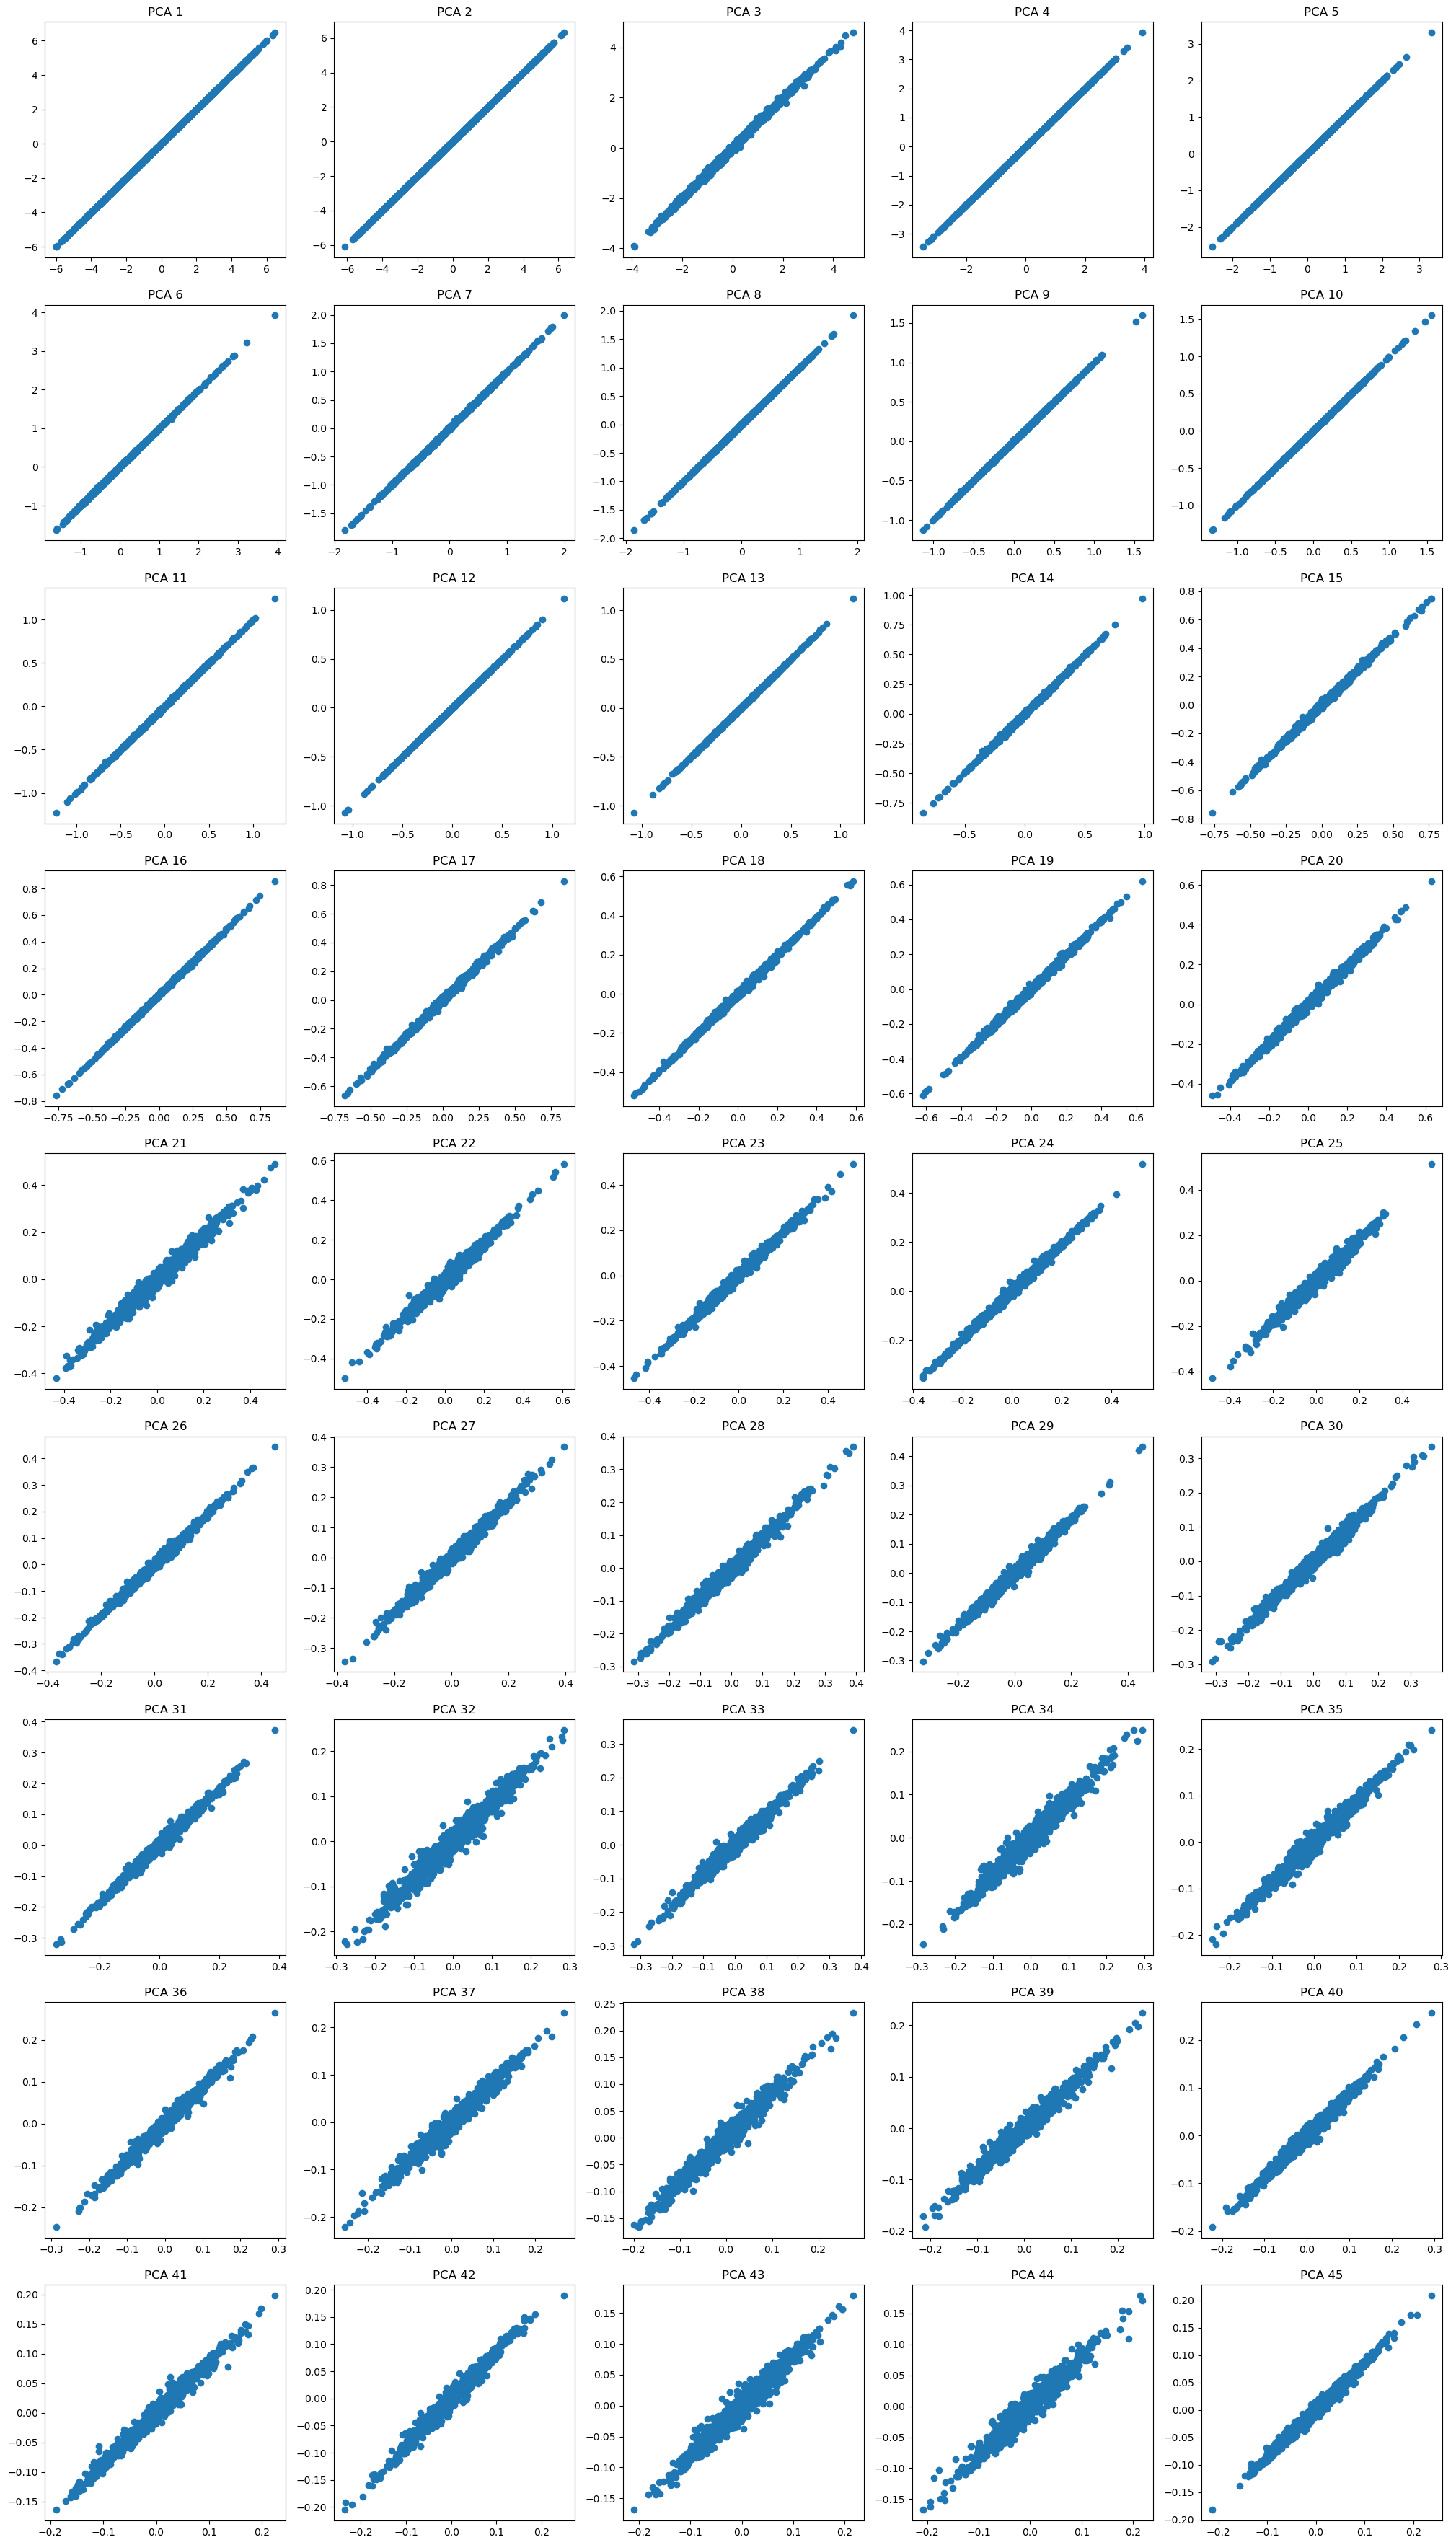

In [76]:
x_train_pca = model.x_test_pca
y_train_pca = model.y_pca.transform(y_train)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_train_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

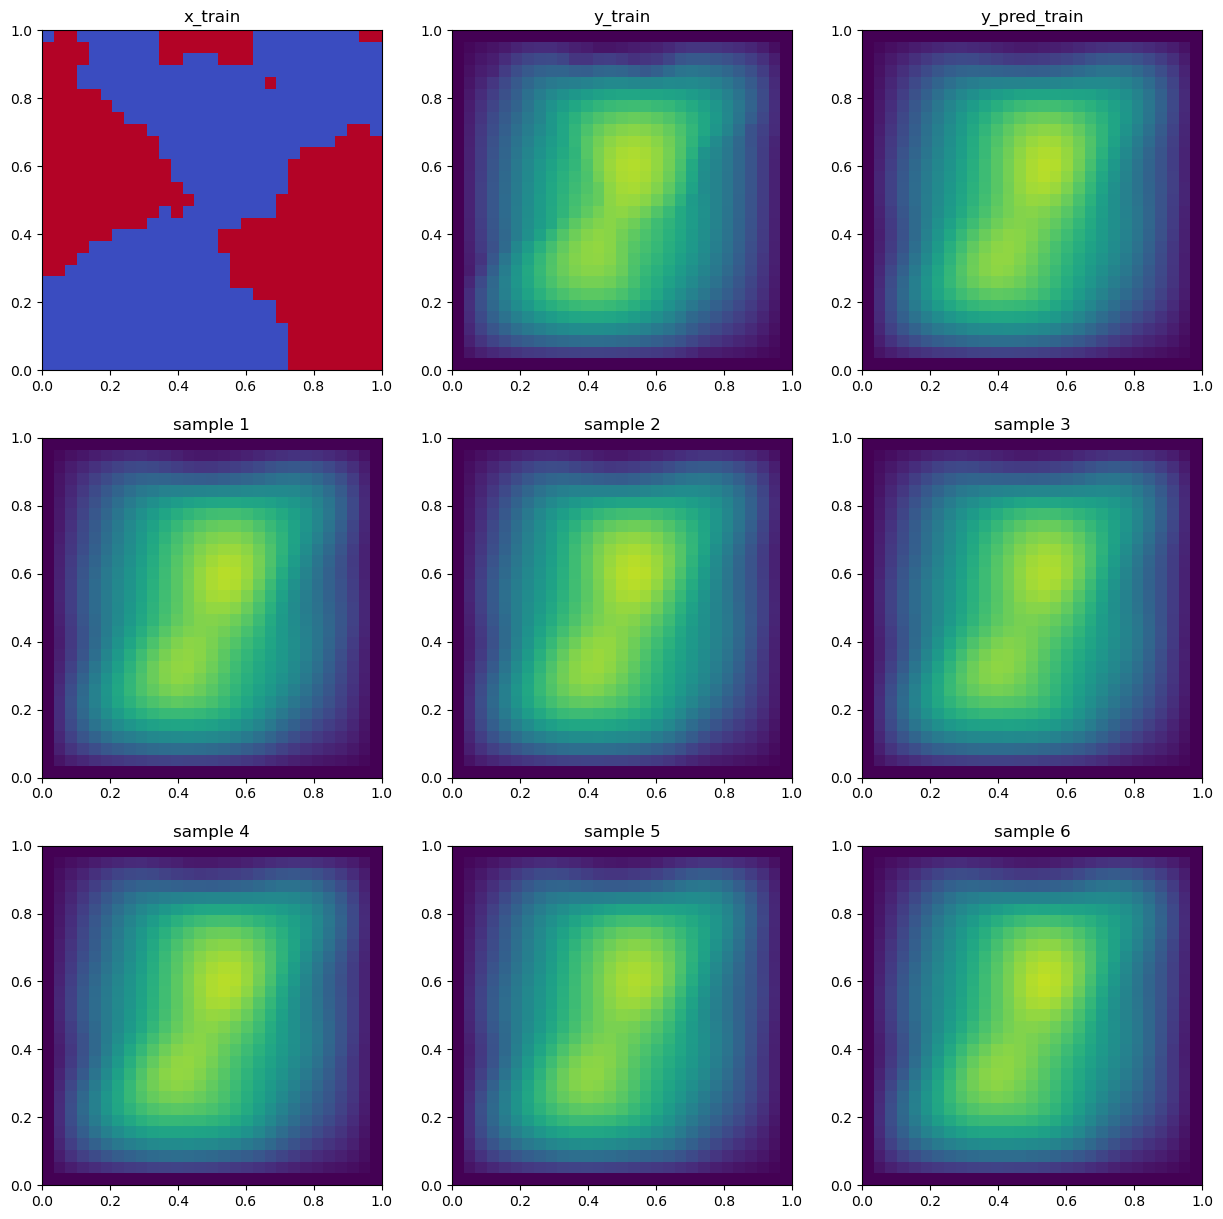

In [89]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap = x_cmap)
ax[0].set_title("x_train")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[1].set_title("y_train")
im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[2].set_title("y_pred_train")
for i in range(6):
    imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

# testing

In [90]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1) / np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


median relative L2: 0.03956848198930879
mean relative L2: 0.041015510574943265


(1000, 841, 6)


IndexError: index 45 is out of bounds for axis 0 with size 45

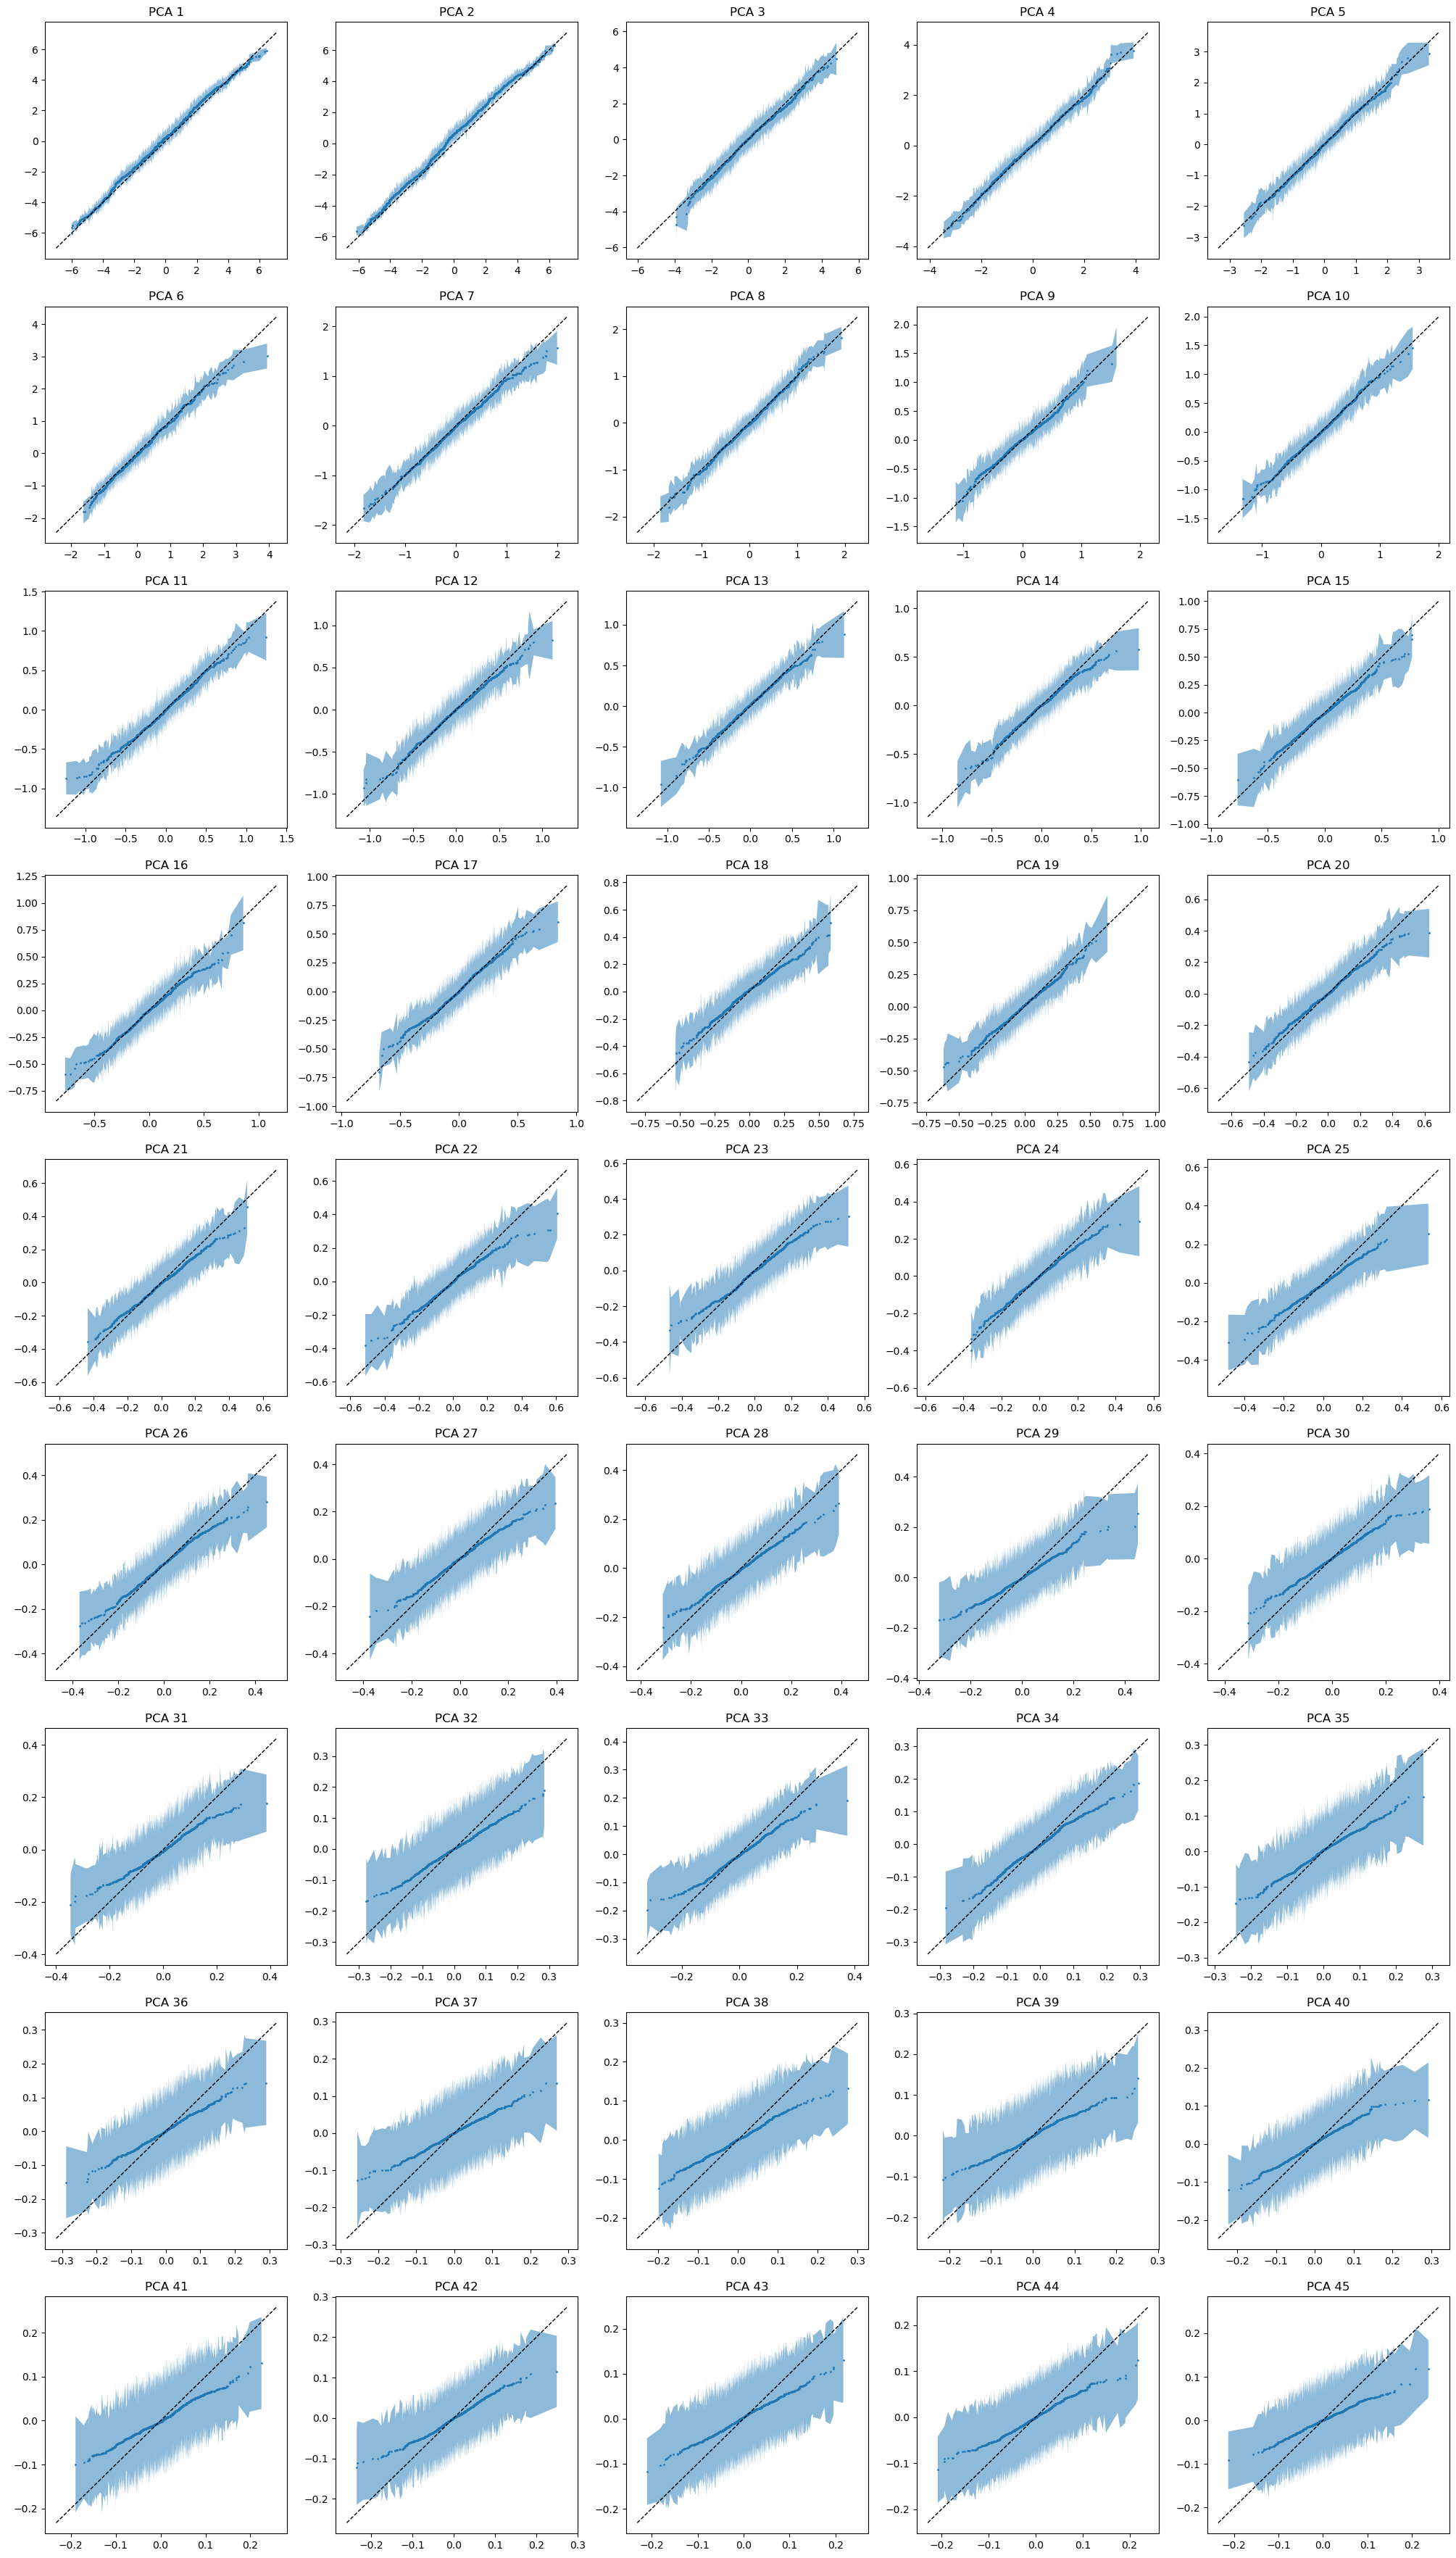

In [79]:
x_test_pca = model.x_test_pca
y_test_pca = model.y_pca.transform(y_test)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(model.y_pred_pca[:, 0, i])], 'o', label = 'true vs pred', ms = 1)
    ax[i].fill_between(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 1, i][np.argsort(model.y_pred_pca[:, 0, i])], model.y_pred_pca[:, 2, i][np.argsort(model.y_pred_pca[:, 0, i])], alpha = 0.5)
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 1, i], 'o', label = r'true vs (pred - 2$\sigma$)')
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 2, i], 'o', label = r'true vs (pred + 2$\sigma$)')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

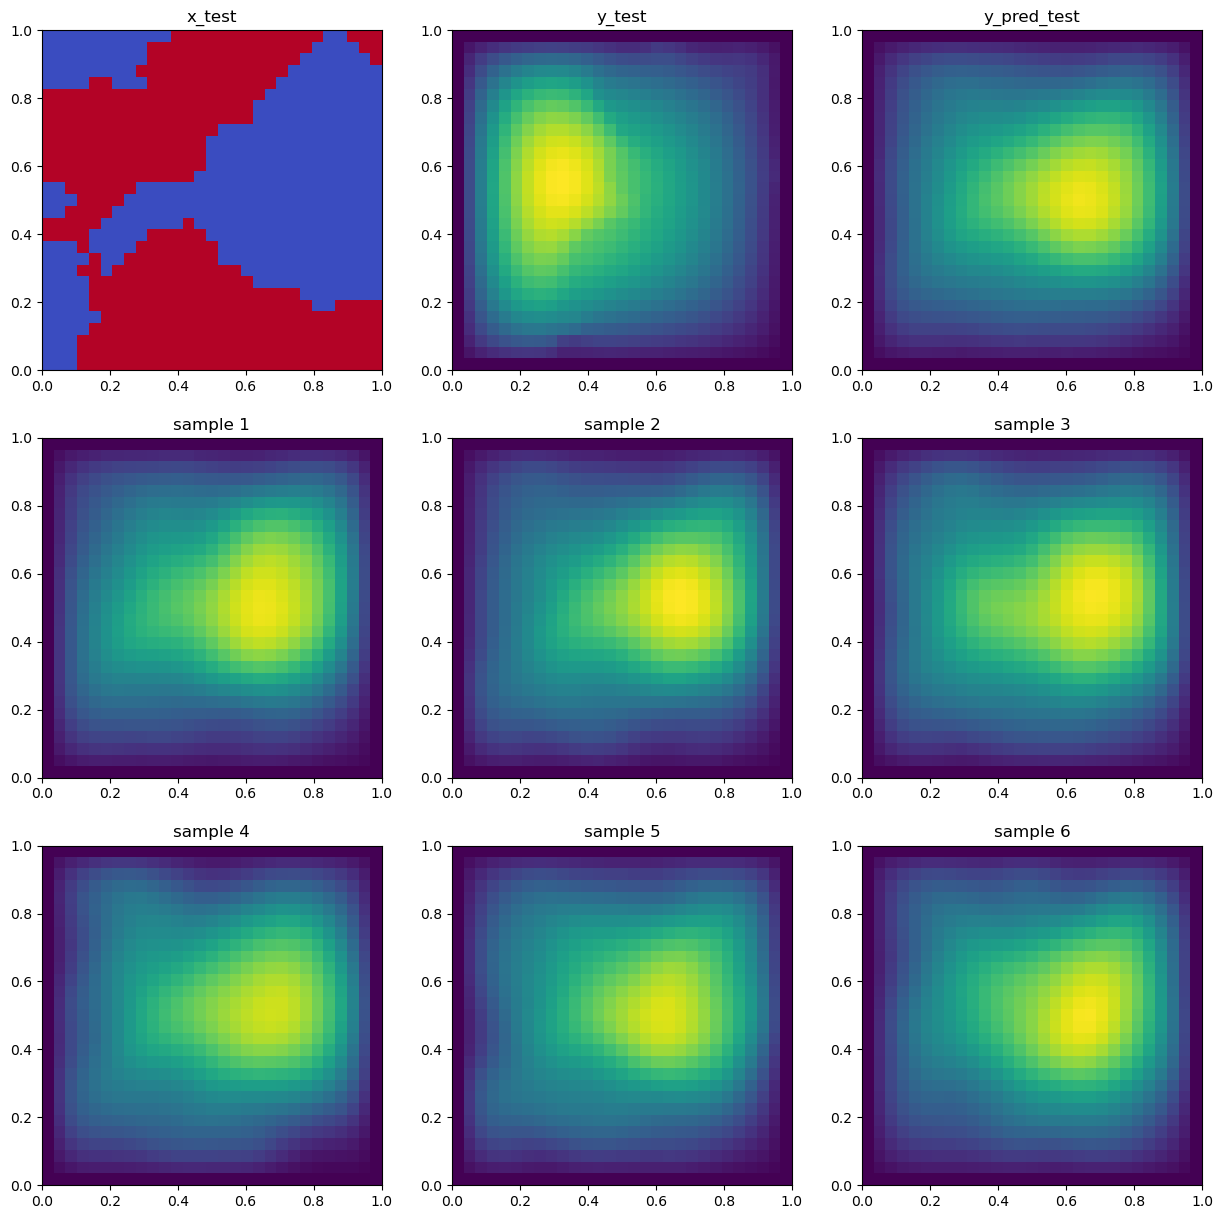

In [82]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap = x_cmap)
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[1].set_title("y_test")
im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[2].set_title("y_pred_test")
for i in range(6):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## analyse uncertainty

In [ ]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(1000, 10201, 100)


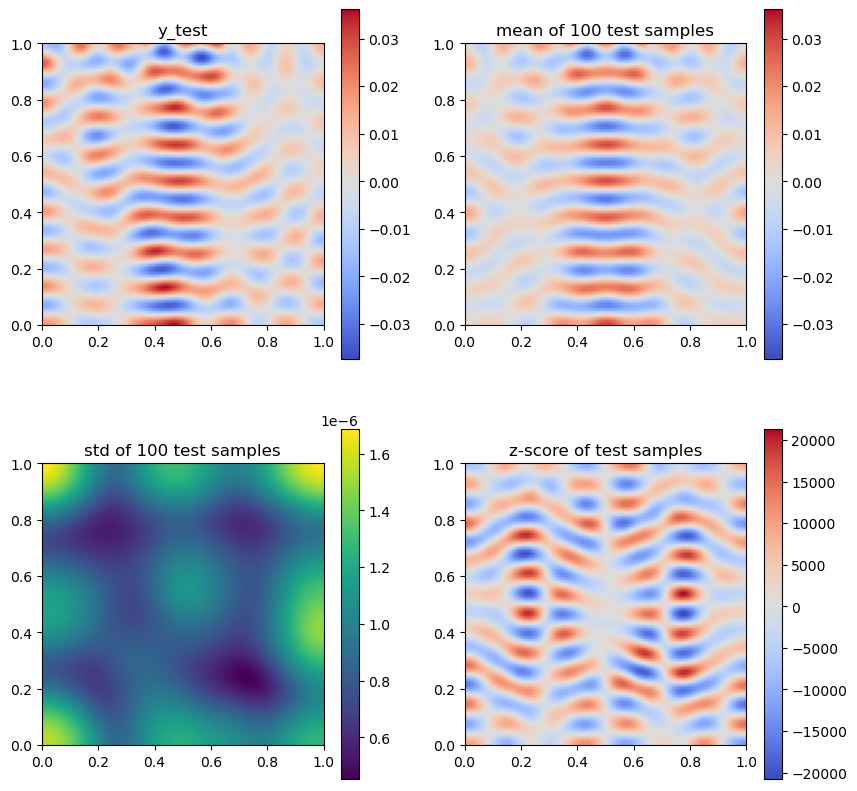

In [ ]:
index_to_plot = 1

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

im0 = ax[0].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[0].set_title("y_test")
im1 = ax[1].imshow(test_samples_mean[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
ax[1].set_title(f"mean of {n_samples} test samples")
im2 = ax[2].imshow(test_samples_std[index_to_plot, :].reshape(s, s), origin='lower', extent=extent)
ax[2].set_title(f"std of {n_samples} test samples")
im3 = ax[3].imshow((y_test[index_to_plot, :].reshape(s, s) - test_samples_mean[index_to_plot, :].reshape(s, s)) / test_samples_std[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm')
ax[3].set_title(f"z-score of test samples")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])


Linear regression baseline

1000 128
0.10237320983538317 0.11867839288962274


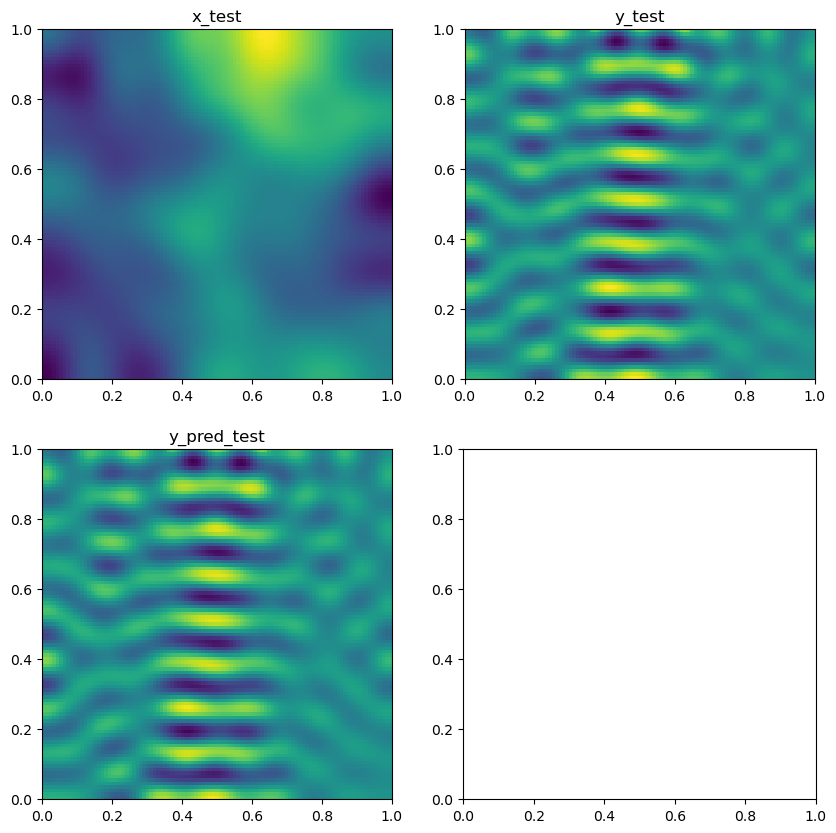

1000 256
0.09654863252019955 0.13610327183221277


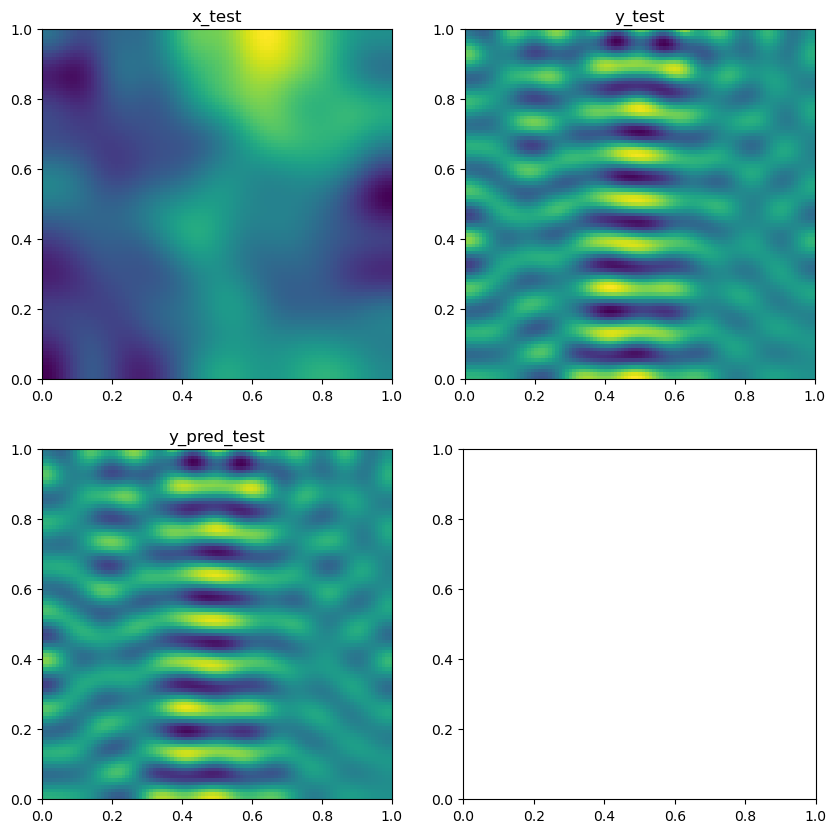

1000 512
0.08052089880378878 0.1764737058195088


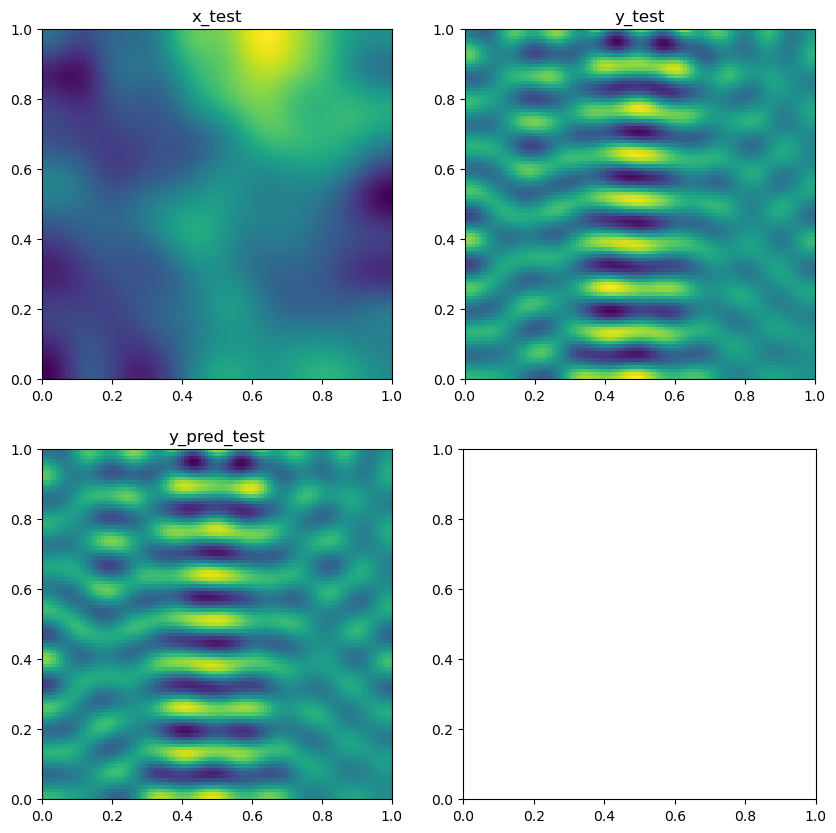

1000 1024
7.409469899050793e-10 0.5303063303091085


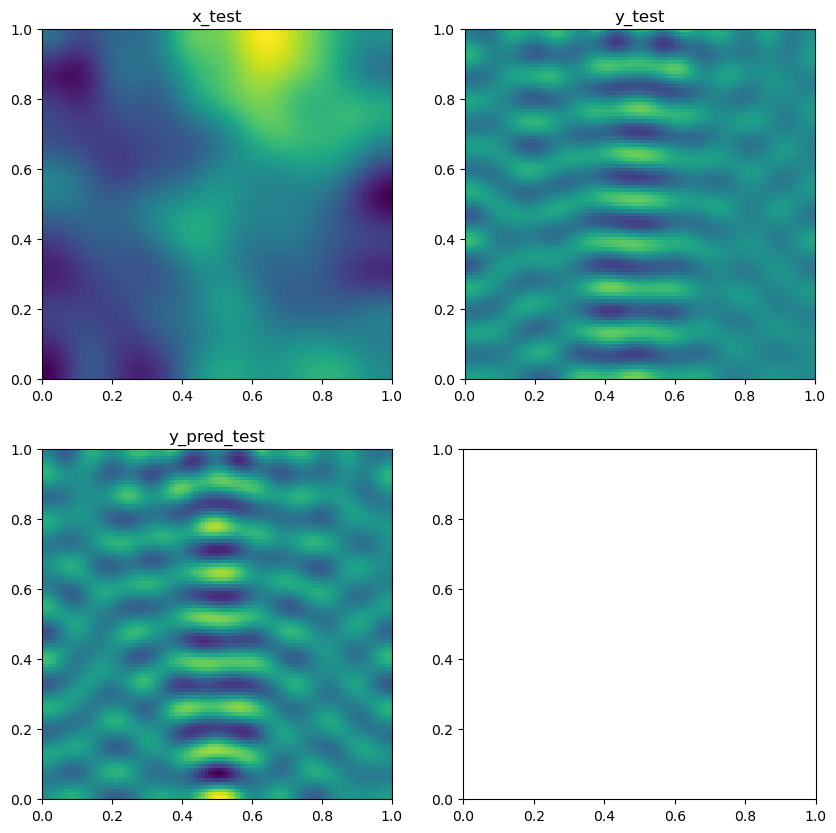

In [ ]:
results = []
for Ntrain in [1000]:
    for N_components in [128, 256, 512, 1024]:
        print(Ntrain, N_components)
        Ytr = y_train
        Xtr = x_train
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        #Ypred Ypredtr = reg.predict(Xtr)
        Ypredtr = reg.predict(Xtr)
        train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        Xtest = x_test
        Ytest = y_test
        Xtest = pca.transform(Xtest)
        Ypred = reg.predict(Xtest)
        test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(train_error, test_error)
        results.append([Ntrain, N_components, train_error, test_error])

        index_to_plot = 125

        y_lims = np.array([min(y_test[index_to_plot, :].min(), Ypred[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), Ypred[index_to_plot, :].max())])

        fig, ax = plt.subplots(2, 2, figsize = (10, 10))
        ax = ax.flatten()
        im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent)
        ax[0].set_title("x_test")
        im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[1].set_title("y_test")
        im2 = ax[2].imshow(Ypred[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[2].set_title("y_pred_test")
        plt.show()

results = np.array(results)